---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
title: Explainable AI with SpotPython and Pytorch
---

In [1]:
#| echo: false
#| label: imports
import warnings
warnings.filterwarnings("ignore")

In [2]:
#| label: configure_spot
from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename
from spotpython.hyperparameters.values import set_hyperparameter
from math import inf

PREFIX="602_4"

data_set = Diabetes()

fun_control = fun_control_init(
    save_experiment=True,
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

fun = HyperLight().fun


set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,7])
set_hyperparameter(fun_control, "epochs", [10,12])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,9])

design_control = design_control_init(init_size=7)

spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control)

Seed set to 123


Seed set to 123


module_name: light
submodule_name: regression
model_name: NNLinearRegressor


## Running the Hyperparameter Tuning or Loading the Existing Model


In [3]:
#| label: run_experiment
from spotpython.utils.file import get_experiment_filename, load_experiment
import os
overwrite = False
filename = get_experiment_filename(PREFIX)
if os.path.exists(filename) and not overwrite:
    (spot_tuner, fun_control, design_control,
    surrogate_control, optimizer_control) = load_experiment(filename)
else:
    print("File does not exist or overwrite is True. Starting new experiment.")
    res = spot_tuner.run()
# only needed for spotpython version < 0.16.0
fun_control.update({"_L_cond": None})

Loaded experiment from spot_602_4_experiment.pickle


## Results from the Hyperparameter Tuning Experiment

* After the hyperparameter tuning is finished, the following information is available:
    * the `spot_tuner` object and the associated
    * `fun_control` dictionary


In [4]:
#| label: print_results
res = spot_tuner.print_results(print_screen=True)

min y: 2904.1572265625
l1: 7.0
epochs: 12.0
batch_size: 11.0
act_fn: 2.0
optimizer: 1.0
dropout_prob: 0.020311634799104406
lr_mult: 4.322386097111191
patience: 5.0
batch_norm: 0.0
initialization: 1.0


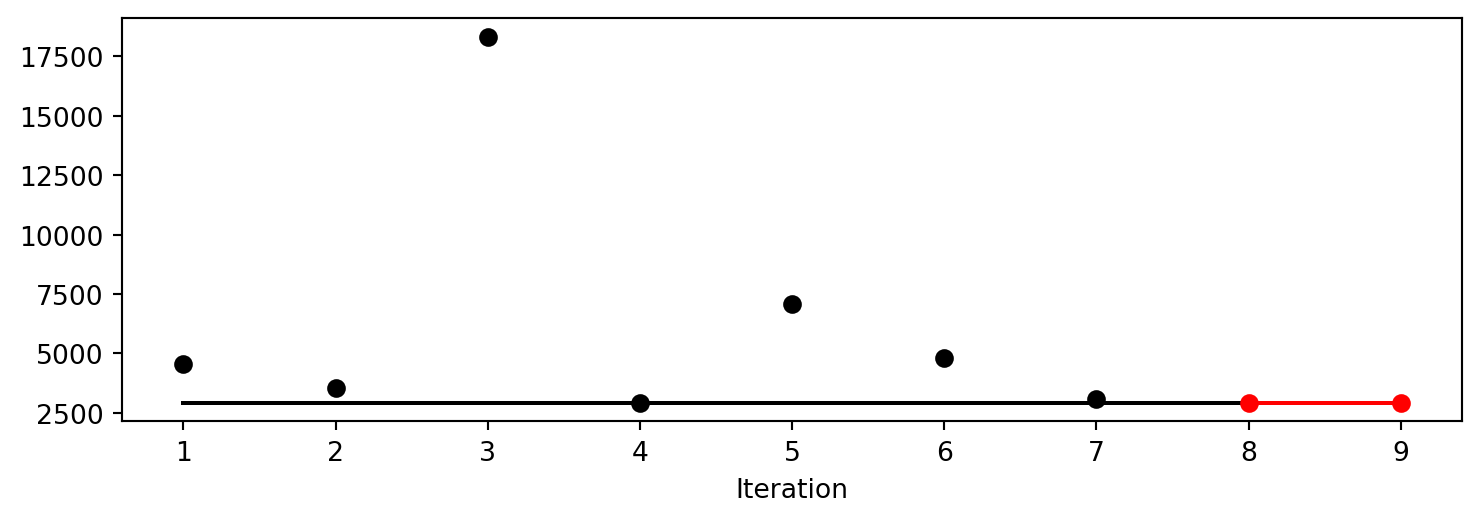

In [5]:
#| label: 602_plot_progress_xai
spot_tuner.plot_progress()

### Getting the Best Model, i.e, the Tuned Architecture

* The method `get_tuned_architecture` [[DOC]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotpython/hyperparameters/values/#spotpython.hyperparameters.values.get_tuned_architecture) returns the best model architecture found during the hyperparameter tuning.
* It returns the transformed values, i.e., `batch_size = 2^x` if the hyperparameter `batch_size` was transformed with the `transform_power_2_int` function.


In [6]:
#| label: get_tuned_architecture
from spotpython.hyperparameters.values import get_tuned_architecture
import pprint
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_norm': False,
 'batch_size': 2048,
 'dropout_prob': 0.020311634799104406,
 'epochs': 4096,
 'initialization': 'kaiming_uniform',
 'l1': 128,
 'lr_mult': 4.322386097111191,
 'optimizer': 'Adam',
 'patience': 32}


* Note: `get_tuned_architecture` has the option `force_minX` which does not have any effect in this case.


In [7]:
#| label: get_tuned_architecture_force_minX
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control, force_minX=True)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_norm': False,
 'batch_size': 2048,
 'dropout_prob': 0.020311634799104406,
 'epochs': 4096,
 'initialization': 'kaiming_uniform',
 'l1': 128,
 'lr_mult': 4.322386097111191,
 'optimizer': 'Adam',
 'patience': 32}


## Training the Tuned Architecture on the Test Data

* Since we are interested in the explainability of the model, we will train the tuned architecture on the test data.
* `spotpythons`'s `test_model` function [[DOC]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotpython/light/testmodel/) is used to train the model on the test data.
* Note: Until now, we do not use any information about the NN's weights and biases. Only the architecture, which is available as the `config`, is used.
* `spotpython` used the TensorBoard logger to save the training process in the `./runs` directory. Therefore, we have to enable the TensorBoard logger in the `fun_control` dictionary. To get a clean start, we remove an existing `runs` folder.


In [8]:
#| label: test_model
from spotpython.light.testmodel import test_model
from spotpython.light.loadmodel import load_light_from_checkpoint
import os
# if the directory "./runs" exists, delete it
if os.path.exists("./runs"):
    os.system("rm -r ./runs")
fun_control.update({"tensorboard_log": True})
test_model(config, fun_control)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TEST/last.ckpt


Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TEST/last.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      2937.9326171875      │
│         val_loss          │      2937.9326171875      │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 2937.9326171875, 'hp_metric': 2937.9326171875}


(2937.9326171875, 2937.9326171875)

In [9]:
#| label: load_model_from_chkpt
model = load_light_from_checkpoint(config, fun_control)

config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TEST from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TEST/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.020311634799104406, inplace=

#### Details of the Training Process on the Test Data

* The `test_model` method initializes the model with the tuned architecture as follows:

```python
model = fun_control["core_model"](**config, _L_in=_L_in, _L_out=_L_out, _torchmetric=_torchmetric)
```

* Then, the Lightning Trainer is initialized with the `fun_control` dictionary and the model as follows:
    
    ```python
        trainer = L.Trainer(
        default_root_dir=os.path.join(fun_control["CHECKPOINT_PATH"], config_id),
        max_epochs=model.hparams.epochs,
        accelerator=fun_control["accelerator"],
        devices=fun_control["devices"],
        logger=TensorBoardLogger(
            save_dir=fun_control["TENSORBOARD_PATH"],
            version=config_id,
            default_hp_metric=True,
            log_graph=fun_control["log_graph"],
        ),
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=config["patience"], mode="min", strict=False, verbose=False),
            ModelCheckpoint(
                dirpath=os.path.join(fun_control["CHECKPOINT_PATH"], config_id), save_last=True
            ), 
        ],
        enable_progress_bar=enable_progress_bar,
    )
    trainer.fit(model=model, datamodule=dm)    
    test_result = trainer.test(datamodule=dm, ckpt_path="last")
    ```

* As shown in the code above, the last checkpoint ist saved.
* `spotpython`'s method `load_light_from_checkpoint` is used to load the last checkpoint and to get the model's weights and biases. It requires the `fun_control` dictionary and the `config_id` as input to find the correct checkpoint.
* Now, the model is trained and the weights and biases are available.


In [10]:
#| label: model_viz
from torchviz import make_dot
import torch
x = torch.randn(1, 10).requires_grad_(True)
x = x.to("mps")
output = model(x)
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render("model_architecture", format="png")

'model_architecture.png'

![architecture](./model_architecture.png)

## XAI Methods

* `spotpython` provides methods to explain the model's predictions. The following neural network elements can be analyzed: 

### Weights

* Weights are the parameters of the neural network that are learned from the data during training. They connect neurons between layers and determine the strength and direction of the signal sent from one neuron to another. The network adjusts the weights during training to minimize the error between the predicted output and the actual output.
* Interpretation of the weights: A high weight value indicates a strong influence of the input neuron on the output. Positive weights suggest a positive correlation, whereas negative weights suggest an inverse relationship between neurons.

### Activations

* Activations are the outputs produced by neurons after applying an activation function to the weighted sum of inputs. The activation function (e.g., ReLU, sigmoid, tanh) adds non-linearity to the model, allowing it to learn more complex relationships.
* Interpretation of the activations: The value of activations indicates the intensity of the signal passed to the next layer. Certain activation patterns can highlight which features or parts of the data the network is focusing on.

### Gradients

* Gradients are the partial derivatives of the loss function with respect to different parameters (weights) of the network. During backpropagation, gradients are used to update the weights in the direction that reduces the loss by methods like gradient descent.
* Interpretation of the gradients: The magnitude of the gradient indicates how much a parameter should change to reduce the error. A large gradient implies a steeper slope and a bigger update, while a small gradient suggests that the parameter is near an optimal point. If gradients are too small (vanishing gradient problem), the network may learn slowly or stop learning. If they are too large (exploding gradient problem), the updates may be unstable.
* `sptpython` provides the method `get_gradients` to get the gradients of the model. 


In [11]:
#| label: import_xai
from spotpython.plot.xai import (get_activations, get_gradients, get_weights, visualize_weights, visualize_gradients, visualize_mean_activations, visualize_gradient_distributions, visualize_weights_distributions, visualize_activations_distributions)
batch_size = config["batch_size"]

### Getting the Weights


In [12]:
#| label: get_weights
from spotpython.plot.xai import sort_layers
weights, _ = get_weights(model)
sort_layers(weights)

{'Layer 0': array([ 0.59957147, -0.70529485, -0.10834173, ...,  0.10424555,
        -0.6733903 ,  0.09644029], dtype=float32),
 'Layer 3': array([ 0.10853875, -0.14742863,  0.18835339, ...,  0.13083038,
        -0.06141461, -0.13379124], dtype=float32),
 'Layer 6': array([ 0.20281036,  0.136719  , -0.04981846, ...,  0.12488467,
        -0.15851991, -0.11625199], dtype=float32),
 'Layer 9': array([ 0.26665238,  0.00139185, -0.1262013 , ...,  0.26803792,
         0.12506701, -0.15335533], dtype=float32),
 'Layer 12': array([-0.25427577, -0.11869553, -0.33531958, ...,  0.07211024,
         0.15451661, -0.43489948], dtype=float32),
 'Layer 15': array([ 0.16652925, -0.02800794,  0.02417073, ...,  0.32888877,
         0.29175386, -0.30372557], dtype=float32),
 'Layer 18': array([ 1.51739836e-01,  2.40855157e-01,  2.94084221e-01,  2.77604938e-01,
         4.76985902e-01, -3.06669950e-01, -1.90745950e-01,  1.66833267e-01,
         3.41541380e-01, -2.64164239e-01, -3.62024128e-01,  2.81584859e-

1280 values in Layer Layer 0. Geometry: (128, 10)


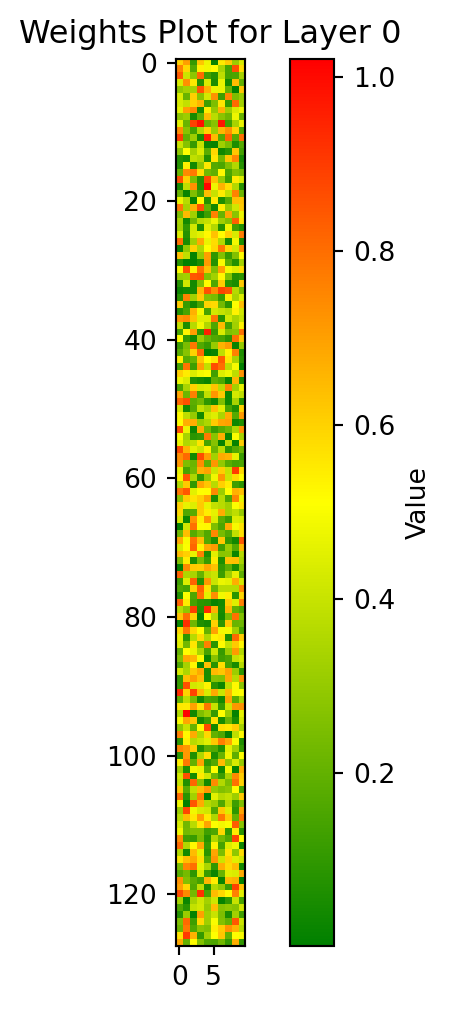

8192 values in Layer Layer 3. Geometry: (64, 128)


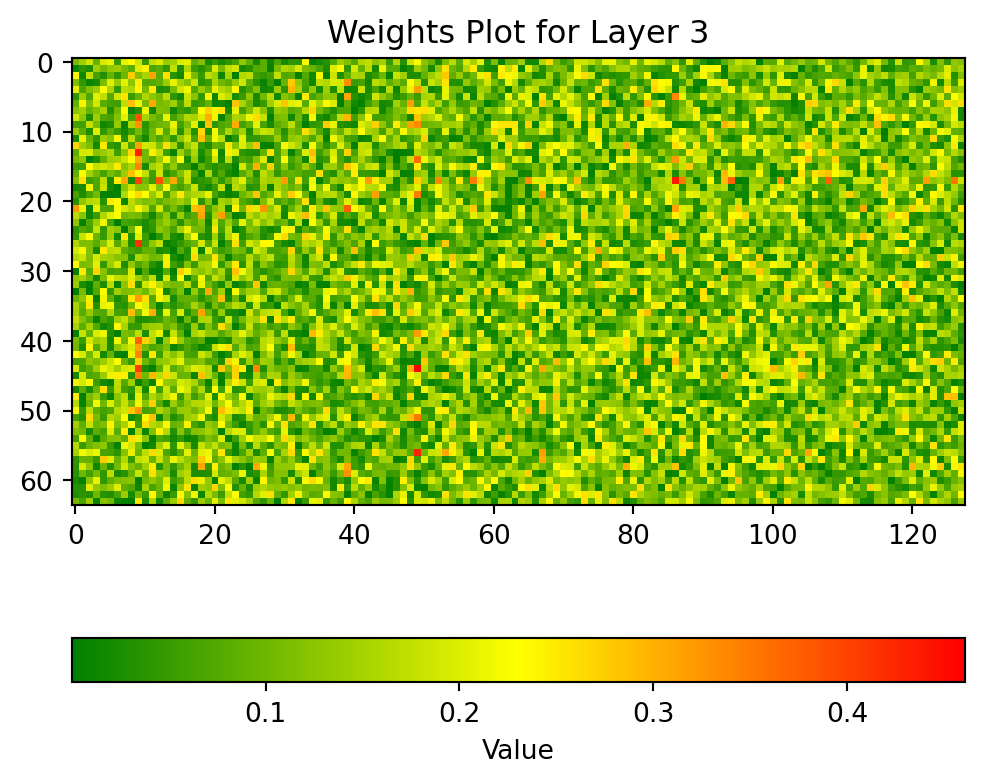

4096 values in Layer Layer 6. Geometry: (64, 64)


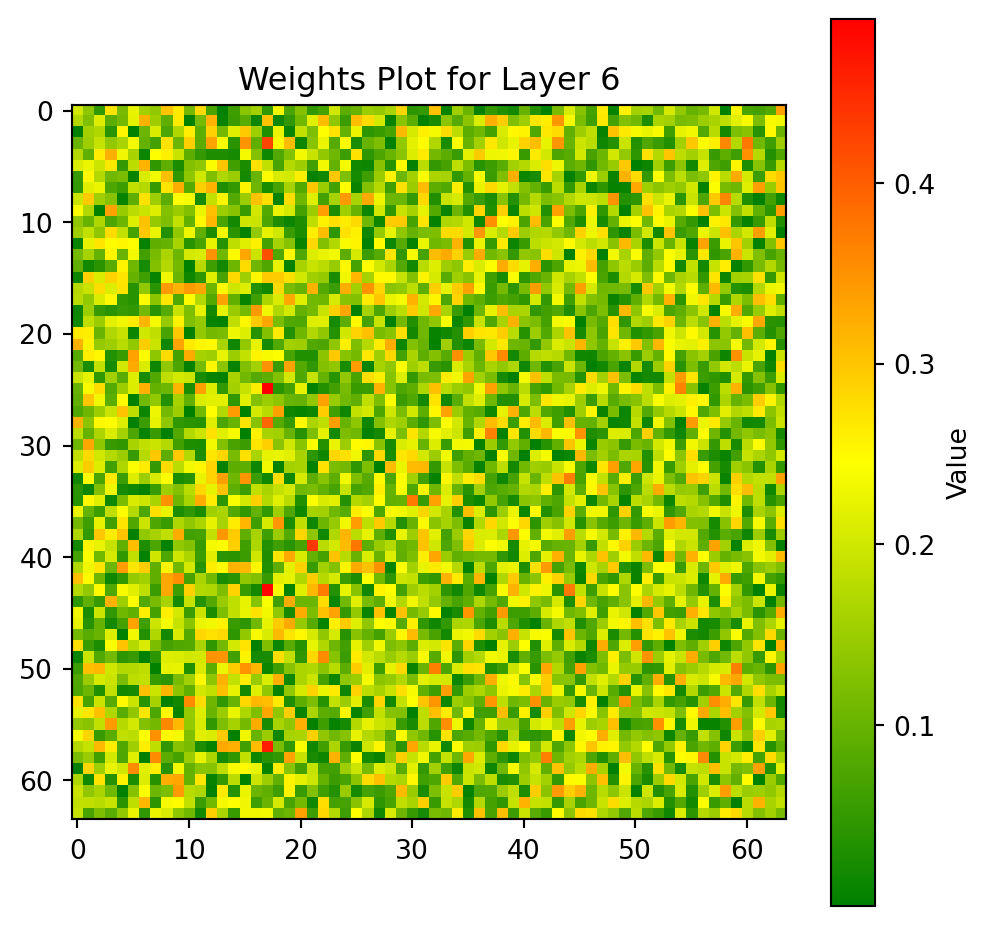

2048 values in Layer Layer 9. Geometry: (32, 64)


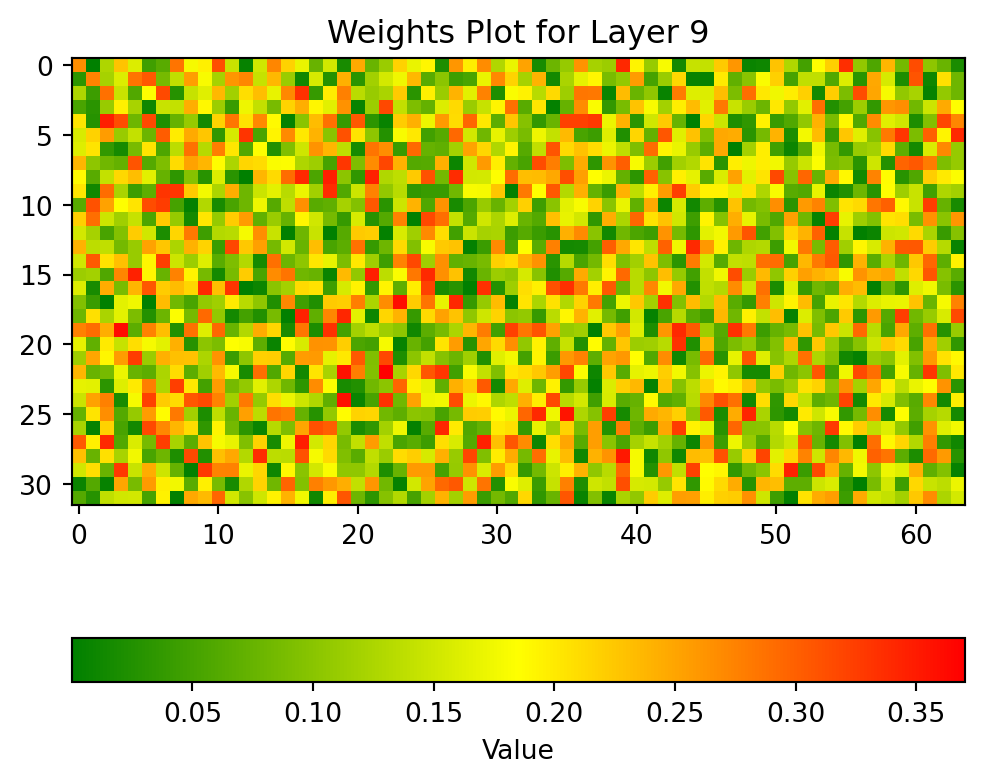

1024 values in Layer Layer 12. Geometry: (32, 32)


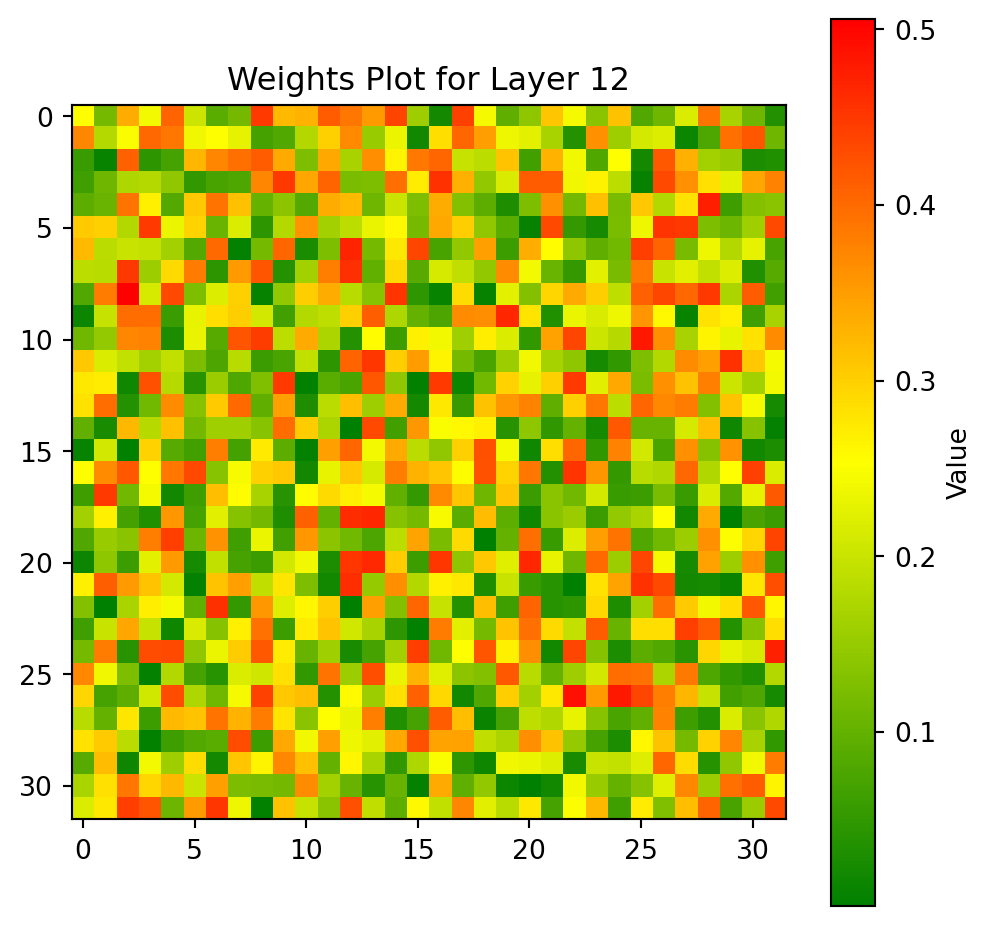

1024 values in Layer Layer 15. Geometry: (32, 32)


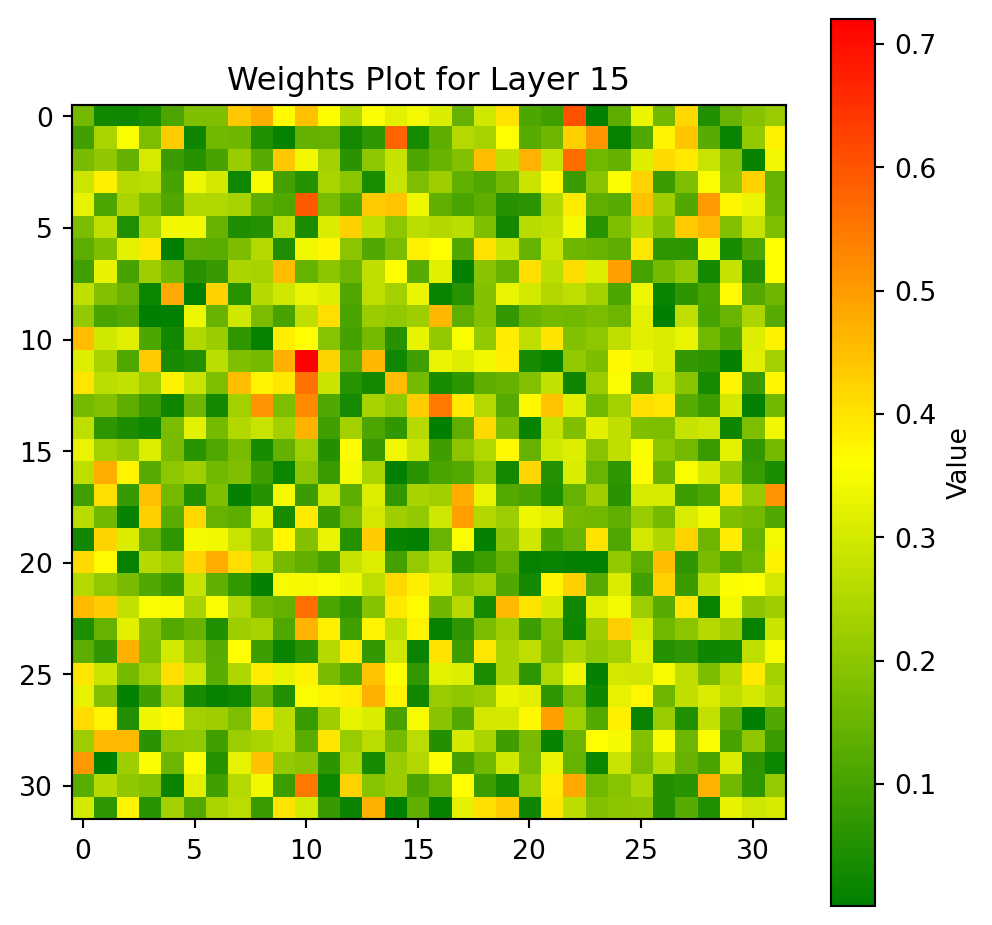

512 values in Layer Layer 18. Geometry: (16, 32)


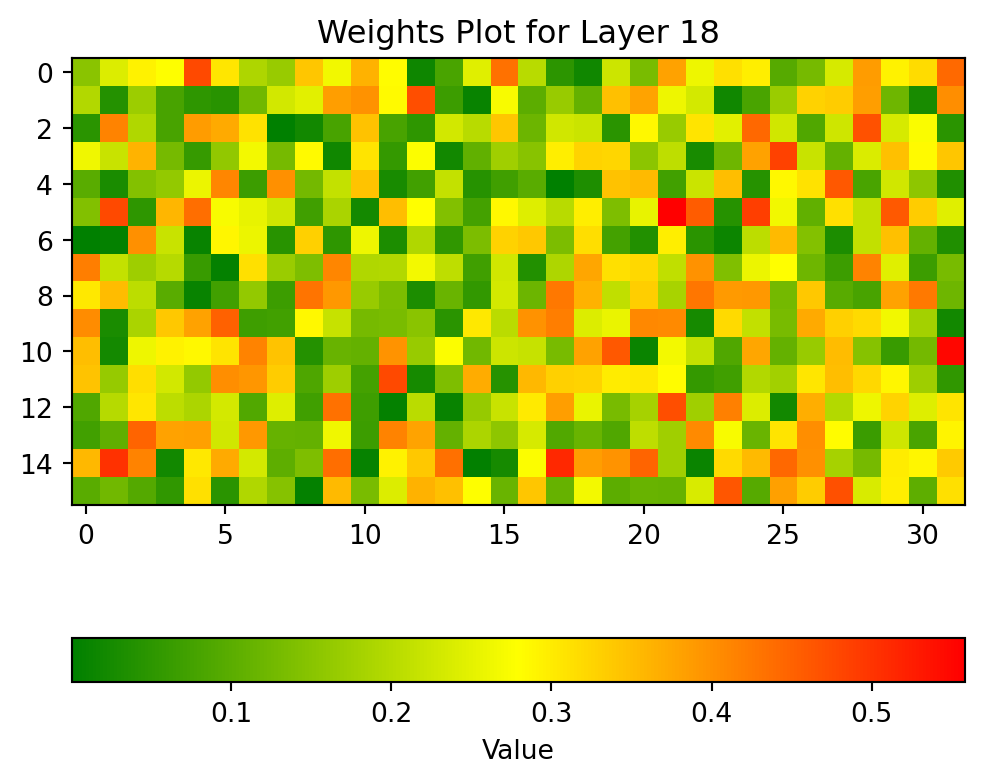

256 values in Layer Layer 21. Geometry: (16, 16)


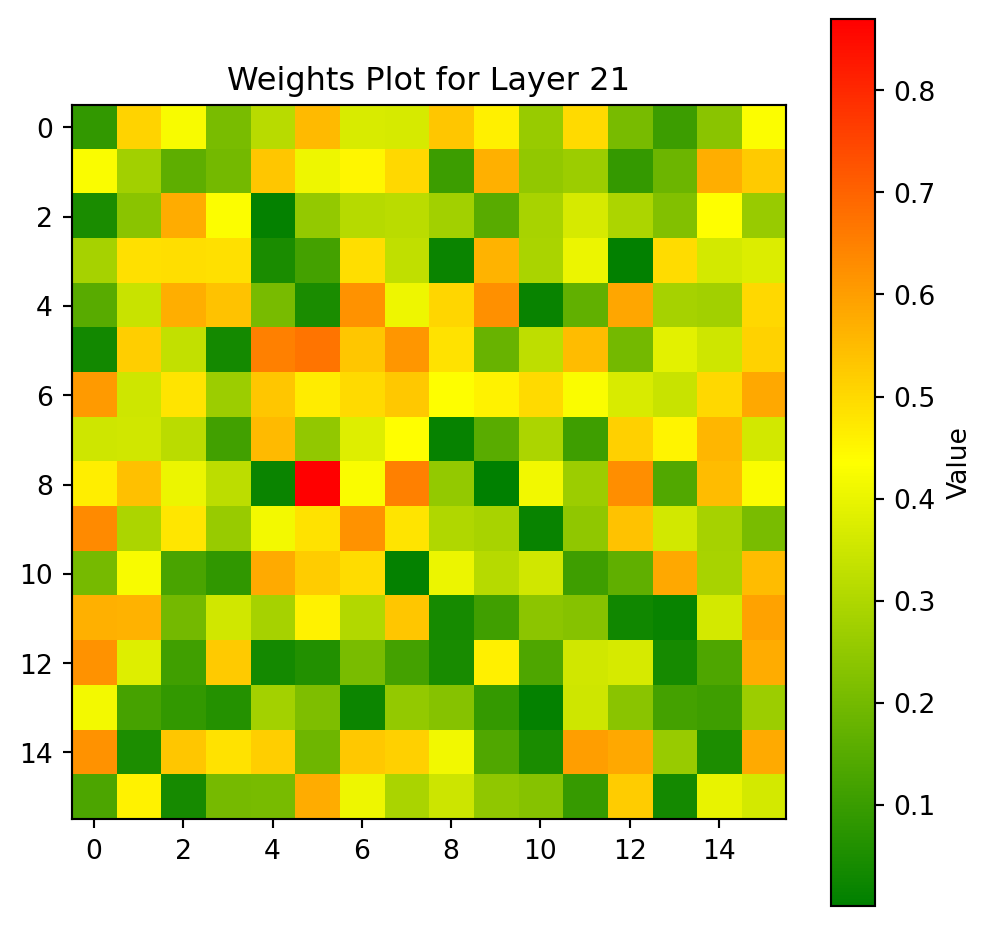

256 values in Layer Layer 24. Geometry: (16, 16)


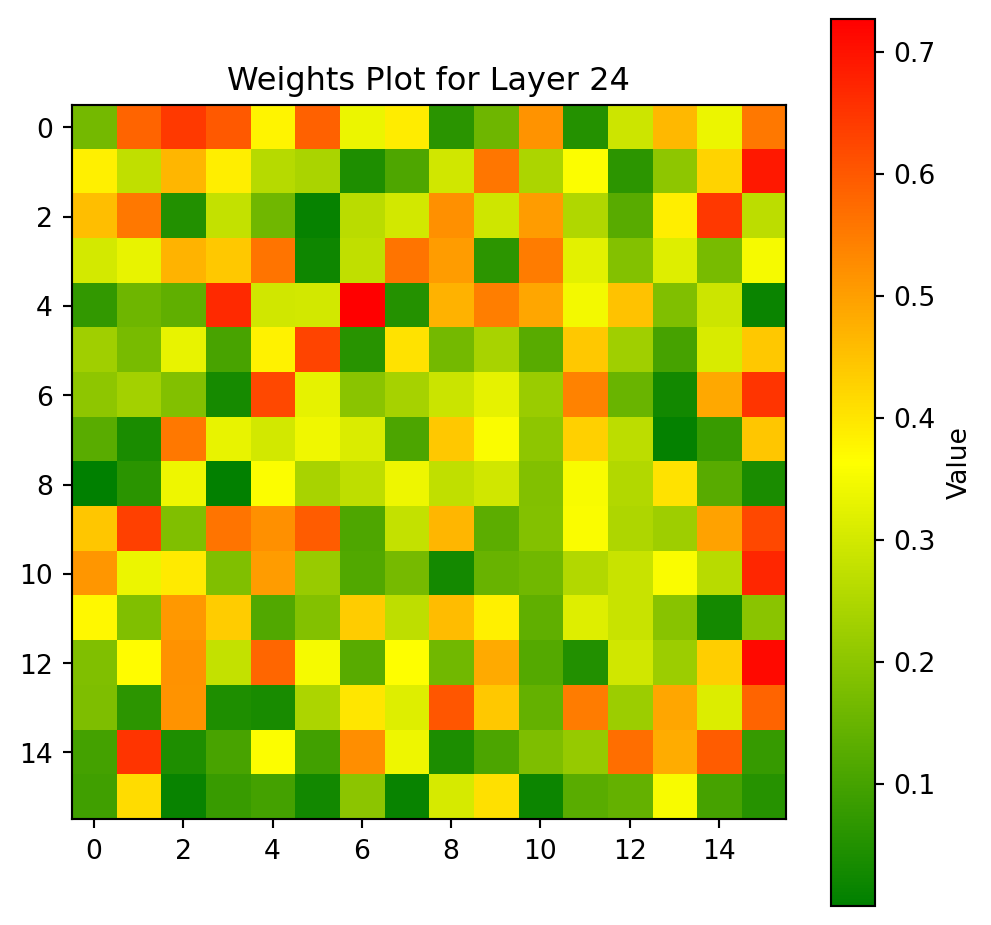

256 values in Layer Layer 27. Geometry: (16, 16)


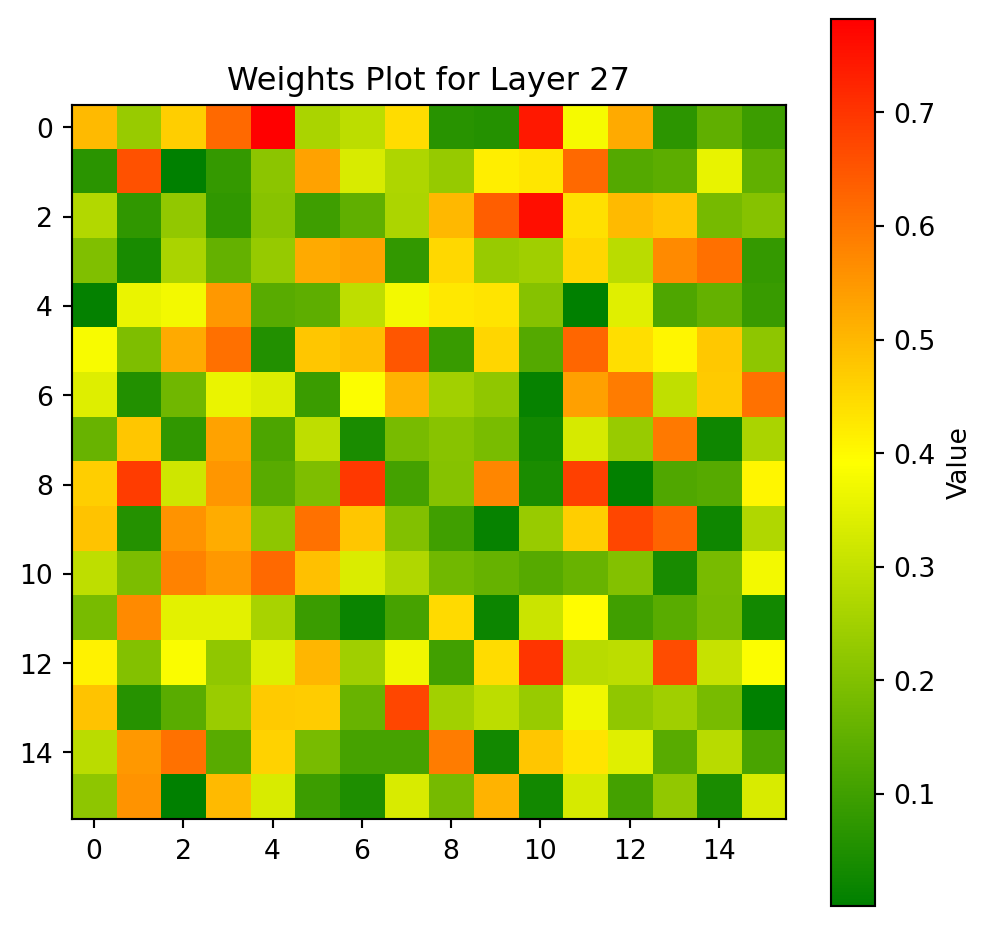

16 values in Layer Layer 30. Geometry: (1, 16)


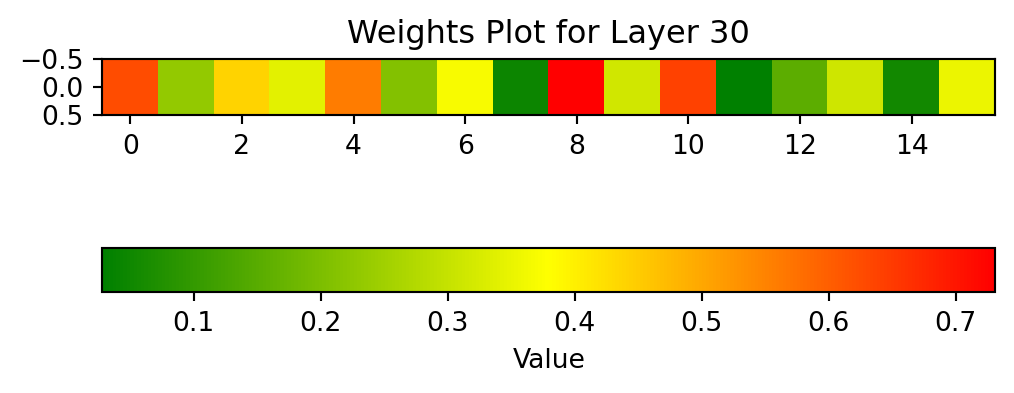

In [13]:
#| label: visualize_weights
visualize_weights(model, absolute=True, cmap="GreenYellowRed", figsize=(6, 6))

n:11


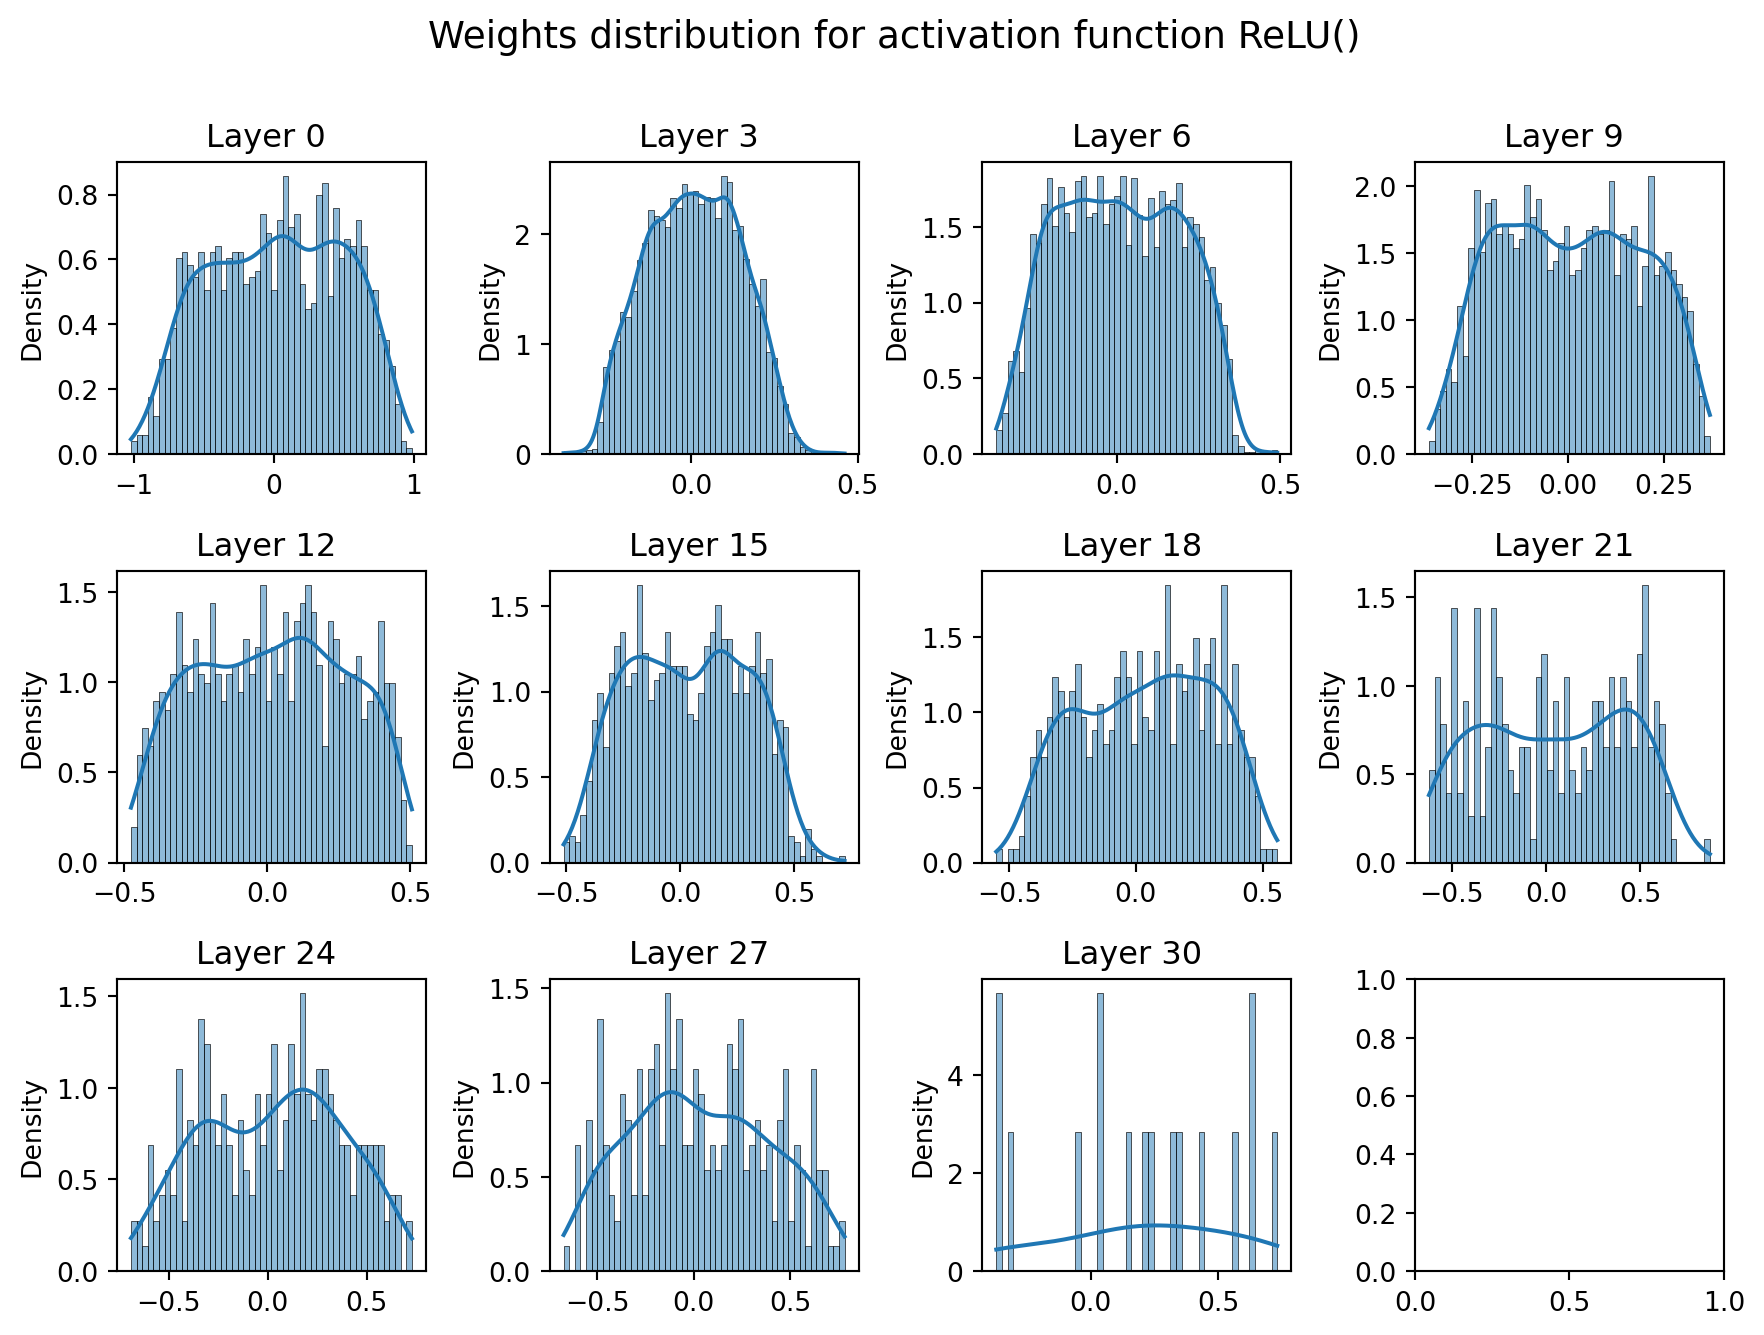

In [14]:
#| label: visualize_weights_distributions
visualize_weights_distributions(model, color=f"C{0}", columns=4)

### Getting the Activations


In [15]:
#| label: get_activations
from spotpython.plot.xai import get_activations
activations, mean_activations, layer_sizes = get_activations(net=model, fun_control=fun_control, batch_size=batch_size, device="mps")

stage: fit
full_sizefull_train_size: 0.6
full_sizeval_size: 0.24
full_sizetrain_size: 0.36
full_sizetest_size: 0.4
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.train_dataloader(). data_train size: 160


128 values in Layer 0. Geometry: (1, 128)


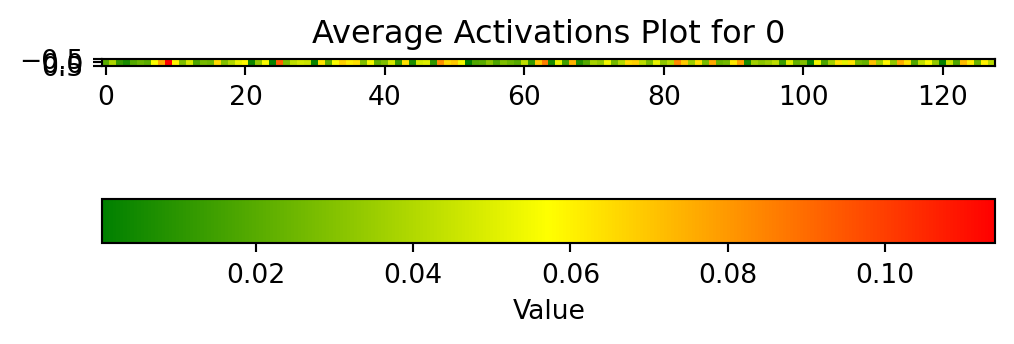

64 values in Layer 3. Geometry: (1, 64)


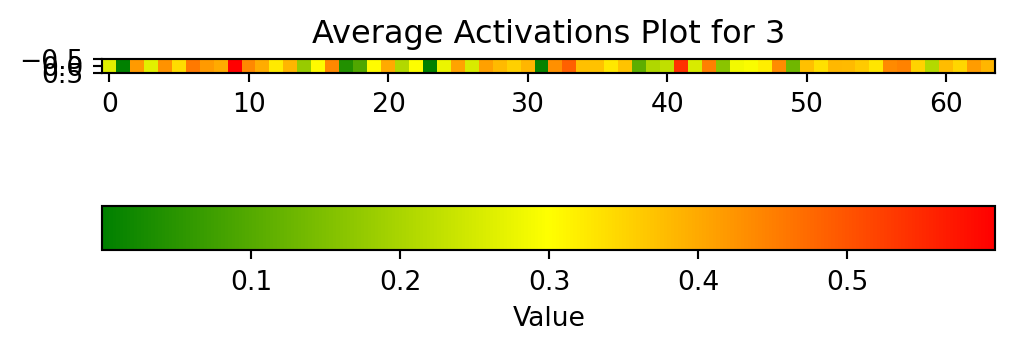

64 values in Layer 6. Geometry: (1, 64)


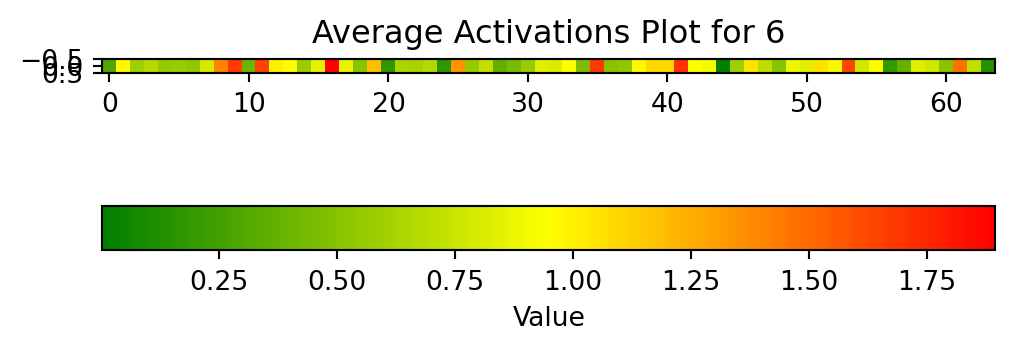

32 values in Layer 9. Geometry: (1, 32)


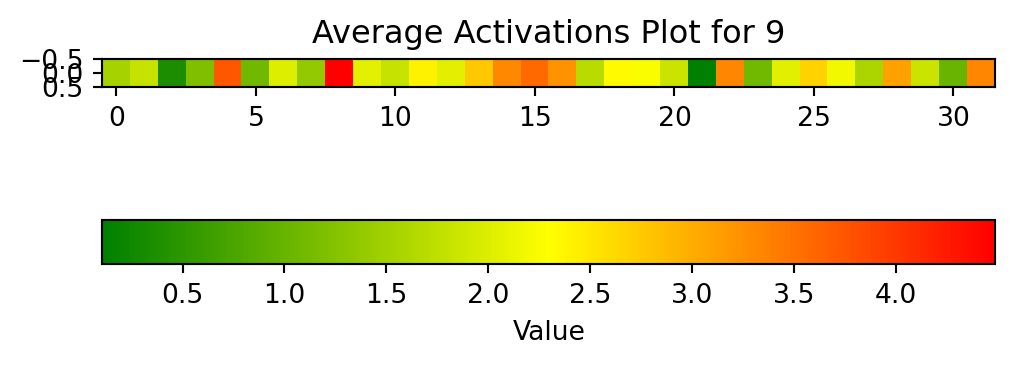

32 values in Layer 12. Geometry: (1, 32)


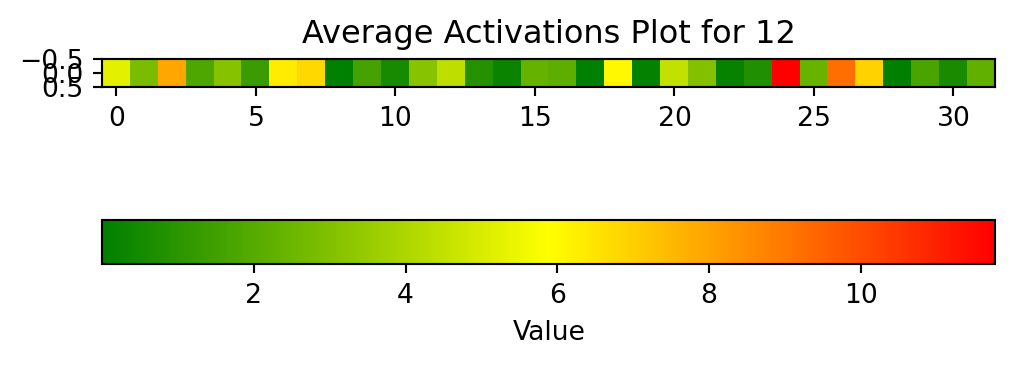

32 values in Layer 15. Geometry: (1, 32)


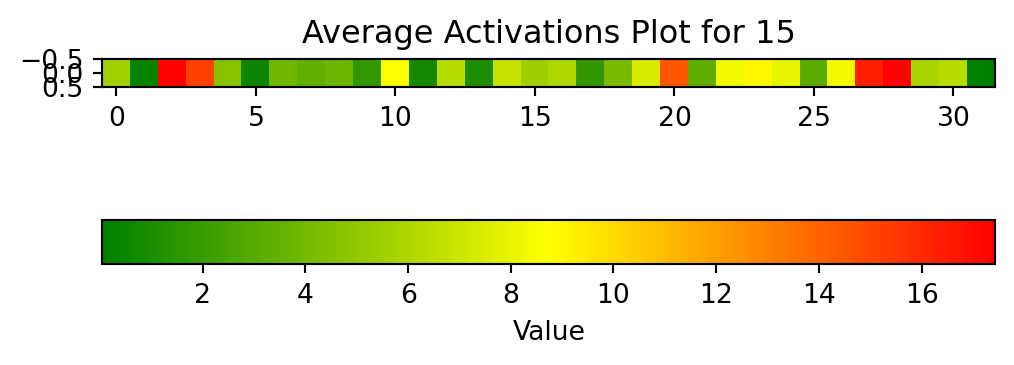

16 values in Layer 18. Geometry: (1, 16)


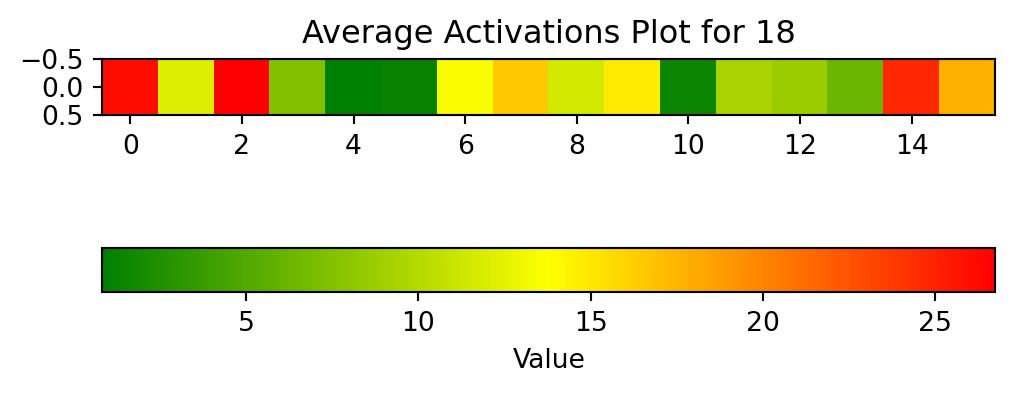

16 values in Layer 21. Geometry: (1, 16)


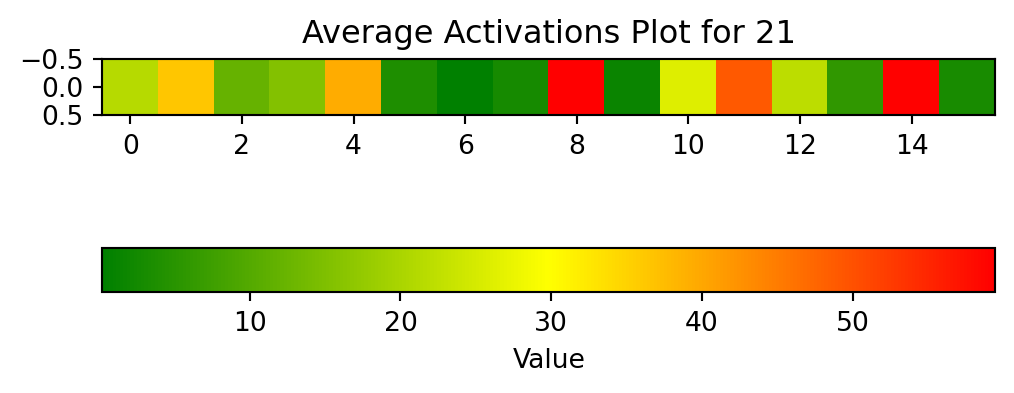

16 values in Layer 24. Geometry: (1, 16)


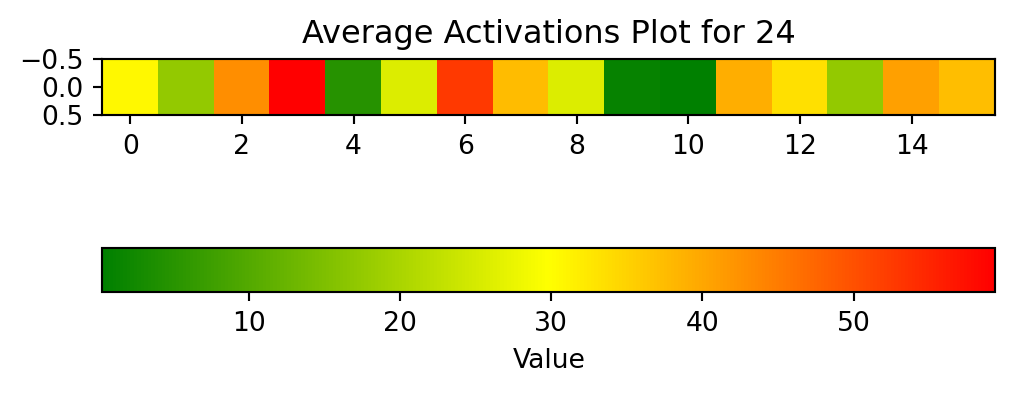

16 values in Layer 27. Geometry: (1, 16)


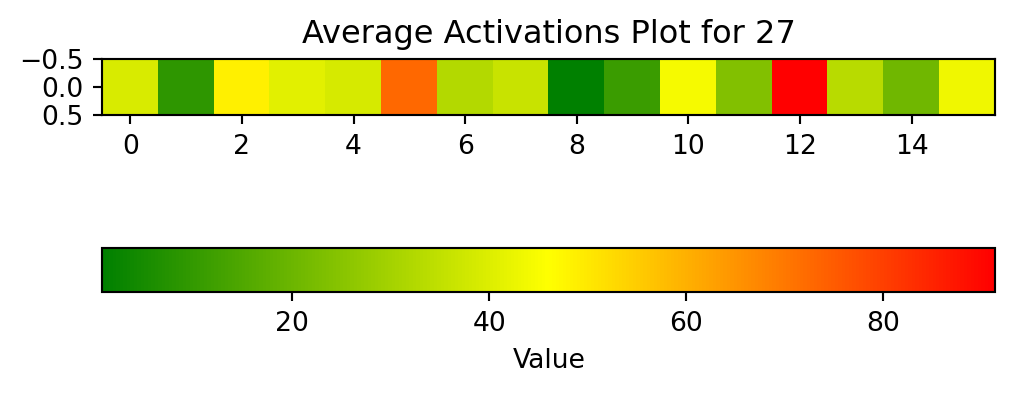

In [16]:
#| label: visualize_mean_activations
visualize_mean_activations(mean_activations, layer_sizes=layer_sizes, absolute=True, cmap="GreenYellowRed", figsize=(6, 6))

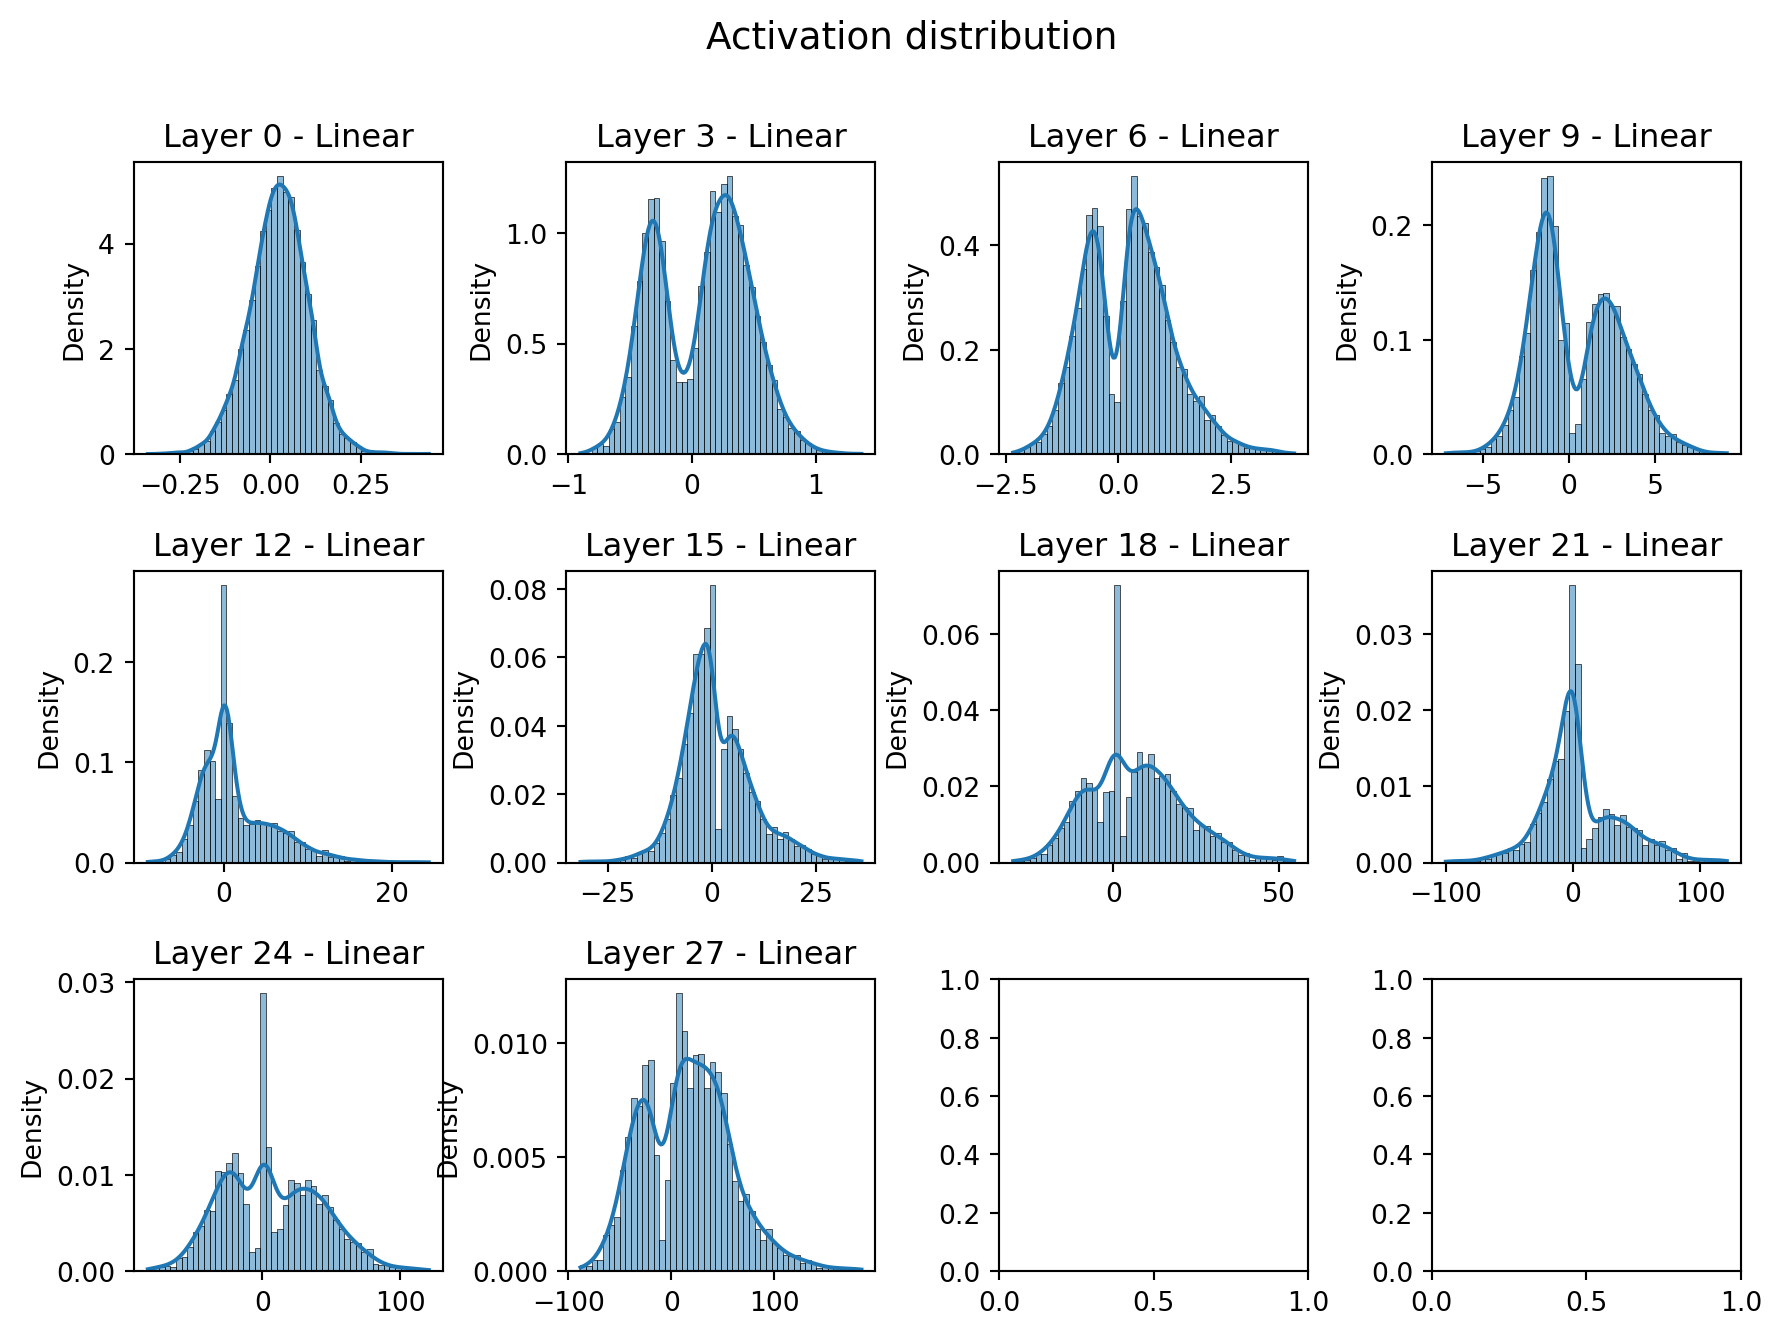

In [17]:
#| label: visualize_activations_distributions
visualize_activations_distributions(activations=activations,
                                    net=model, color="C0", columns=4)

### Getting the Gradients


In [18]:
#| label: get_gradients
gradients, _ = get_gradients(net=model, fun_control=fun_control, batch_size=batch_size, device = "mps")

stage: fit
full_sizefull_train_size: 0.6
full_sizeval_size: 0.24
full_sizetrain_size: 0.36
full_sizetest_size: 0.4
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.train_dataloader(). data_train size: 160


stage: fit
full_sizefull_train_size: 0.6
full_sizeval_size: 0.24
full_sizetrain_size: 0.36
full_sizetest_size: 0.4
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.train_dataloader(). data_train size: 160
1280 values in Layer layers.0.weight. Geometry: (128, 10)


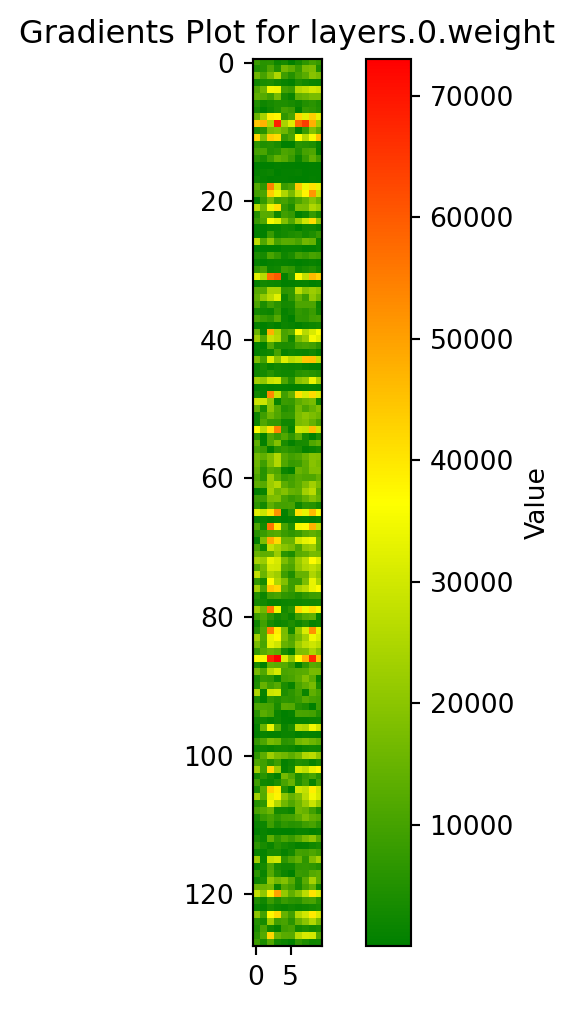

8192 values in Layer layers.3.weight. Geometry: (64, 128)


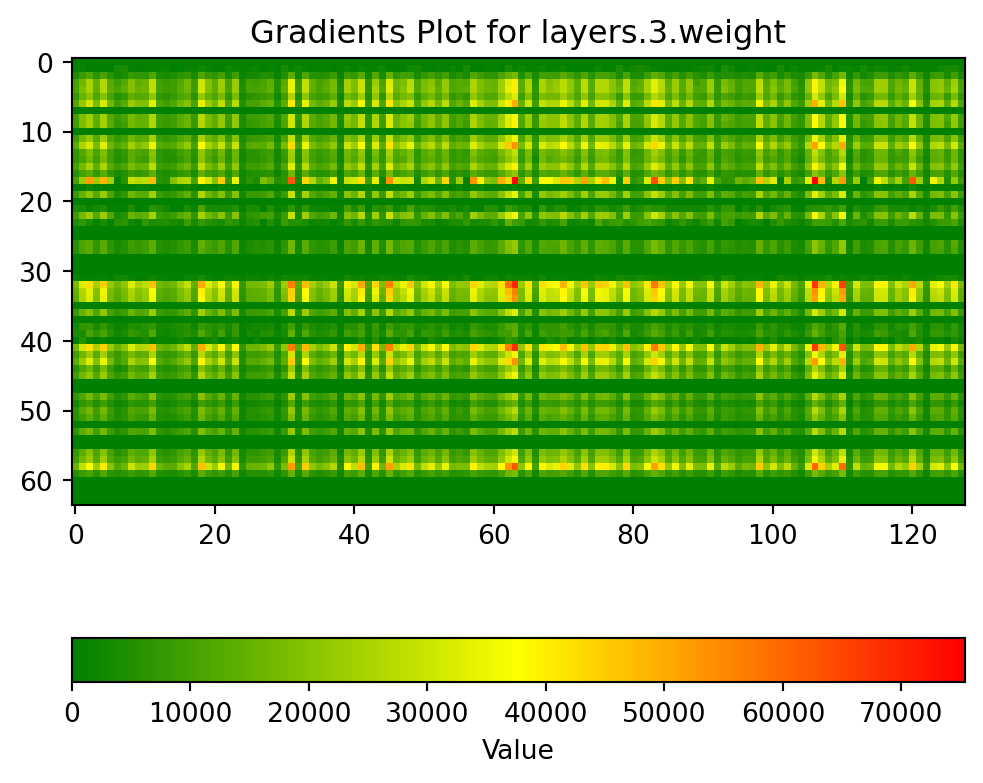

4096 values in Layer layers.6.weight. Geometry: (64, 64)


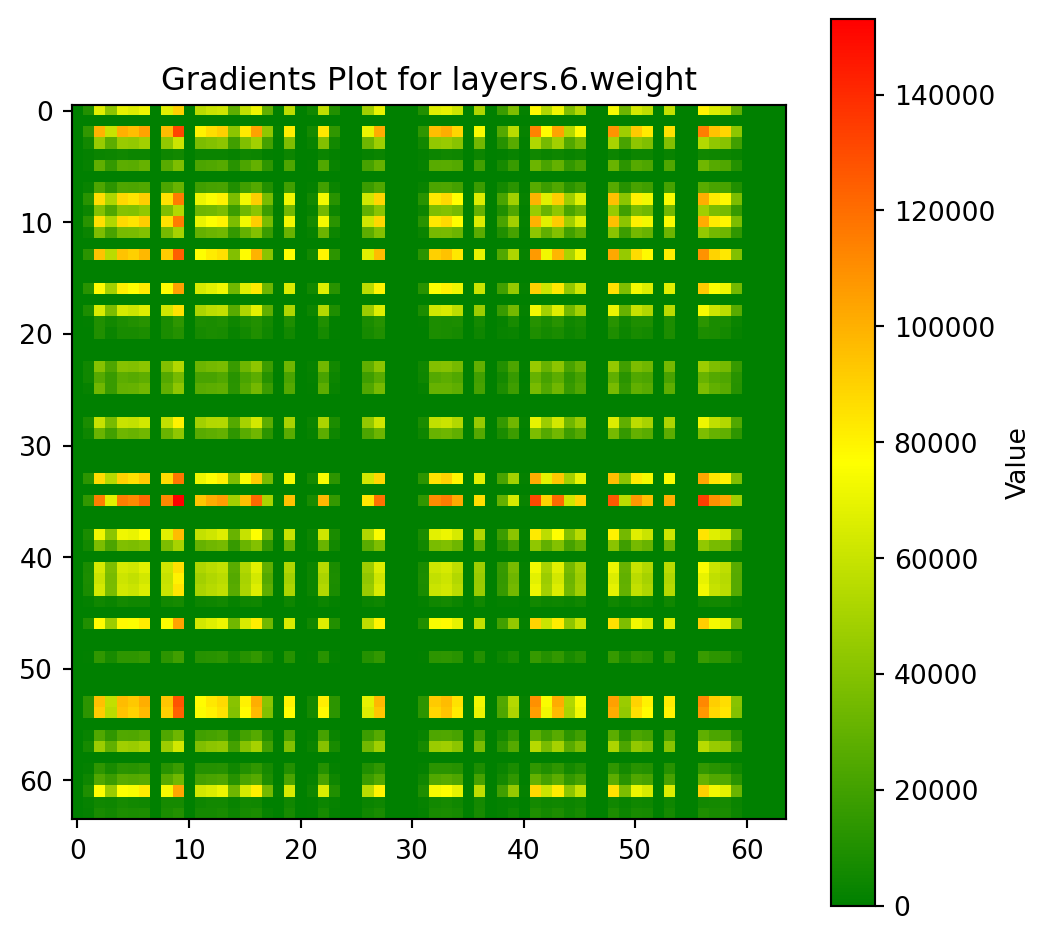

2048 values in Layer layers.9.weight. Geometry: (32, 64)


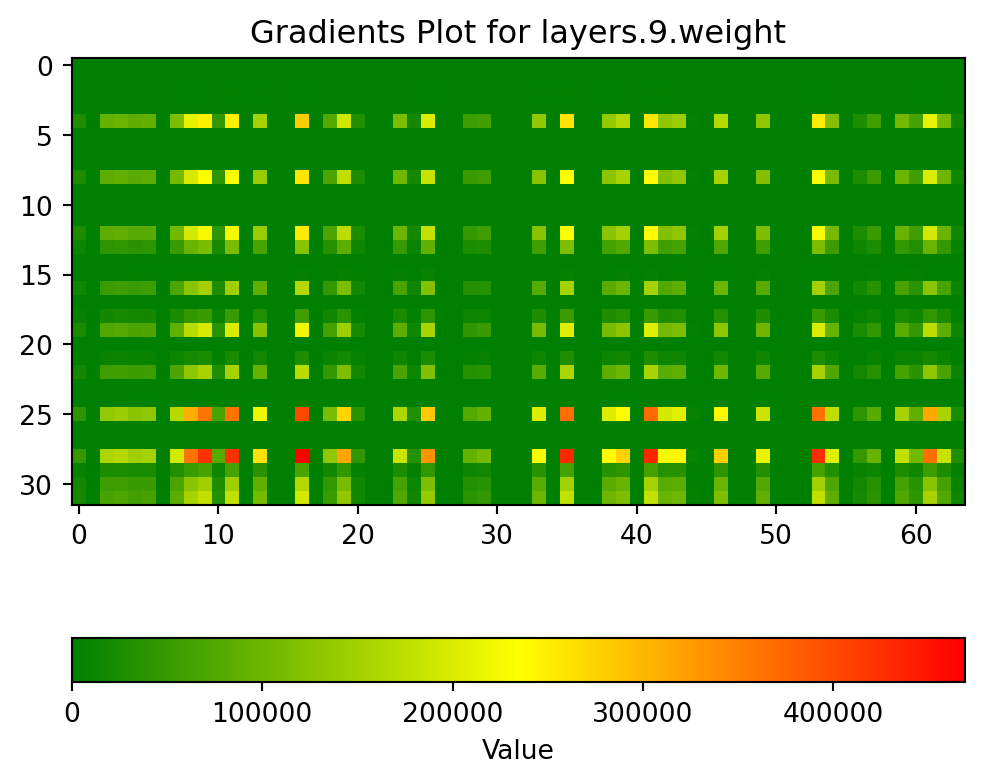

1024 values in Layer layers.12.weight. Geometry: (32, 32)


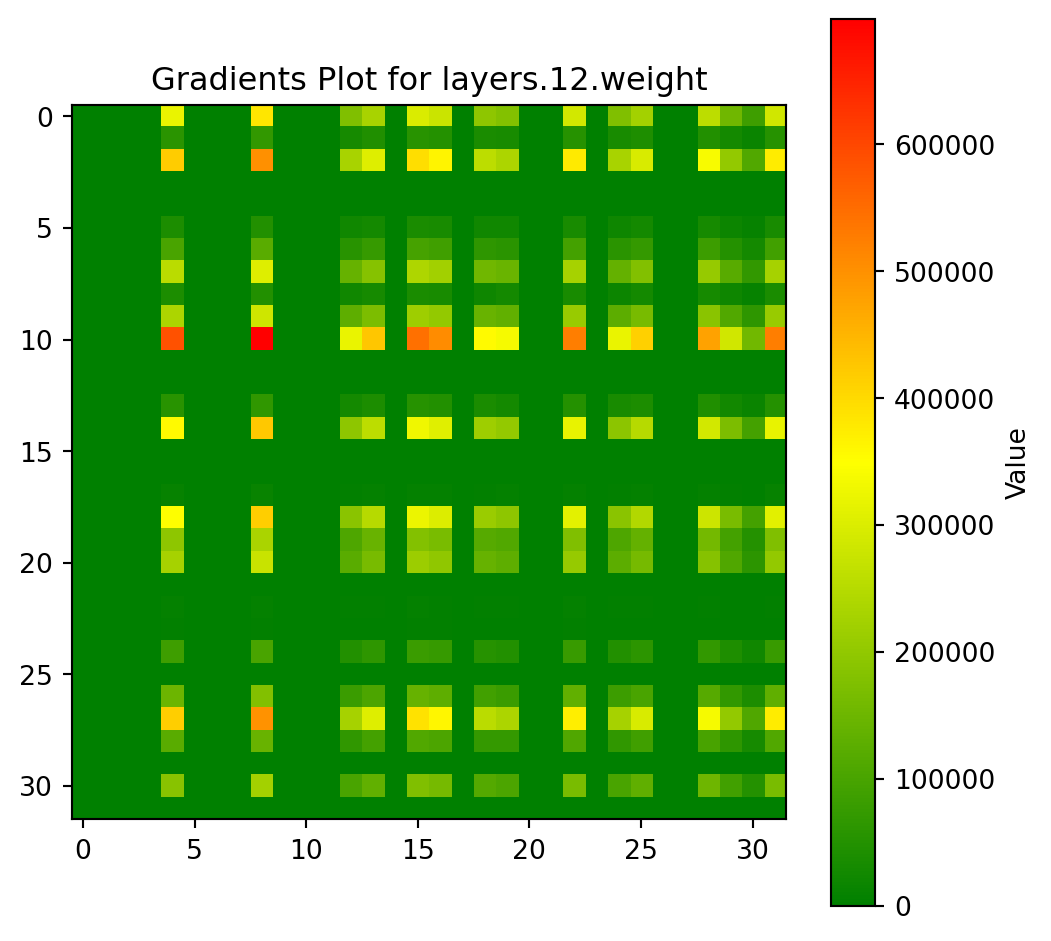

1024 values in Layer layers.15.weight. Geometry: (32, 32)


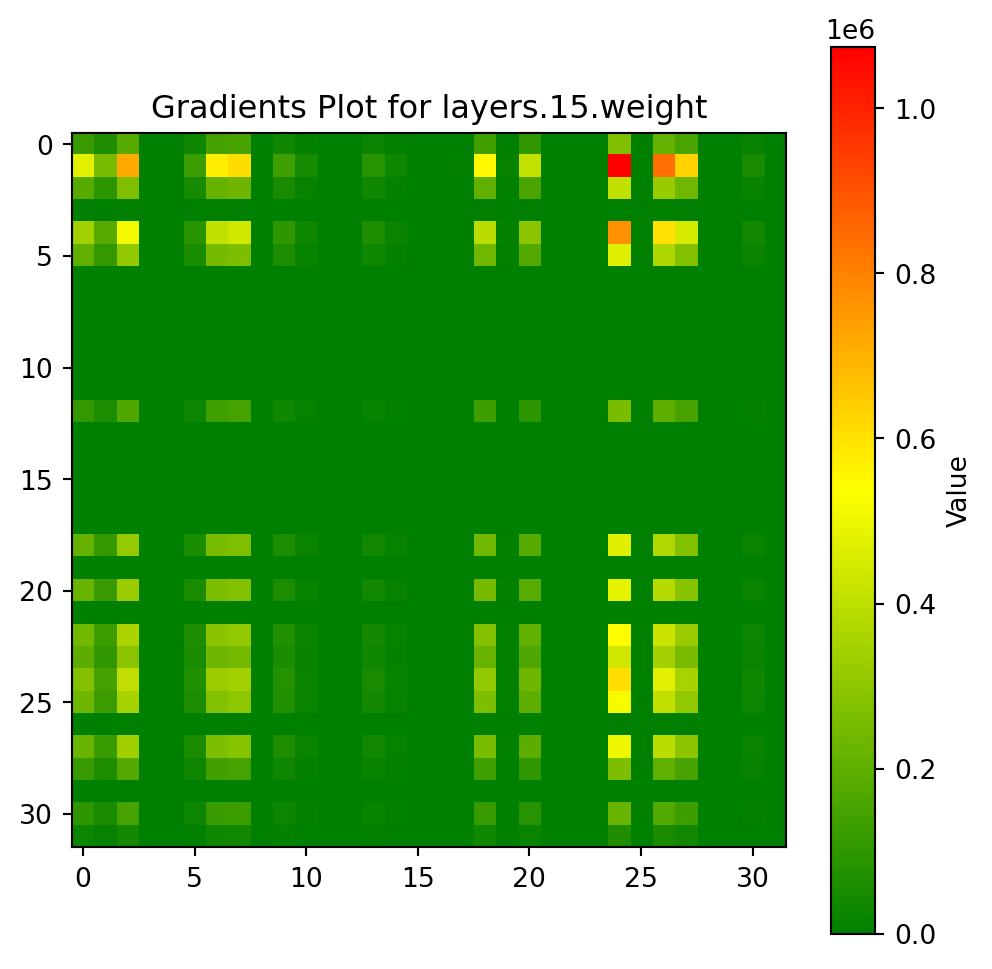

512 values in Layer layers.18.weight. Geometry: (16, 32)


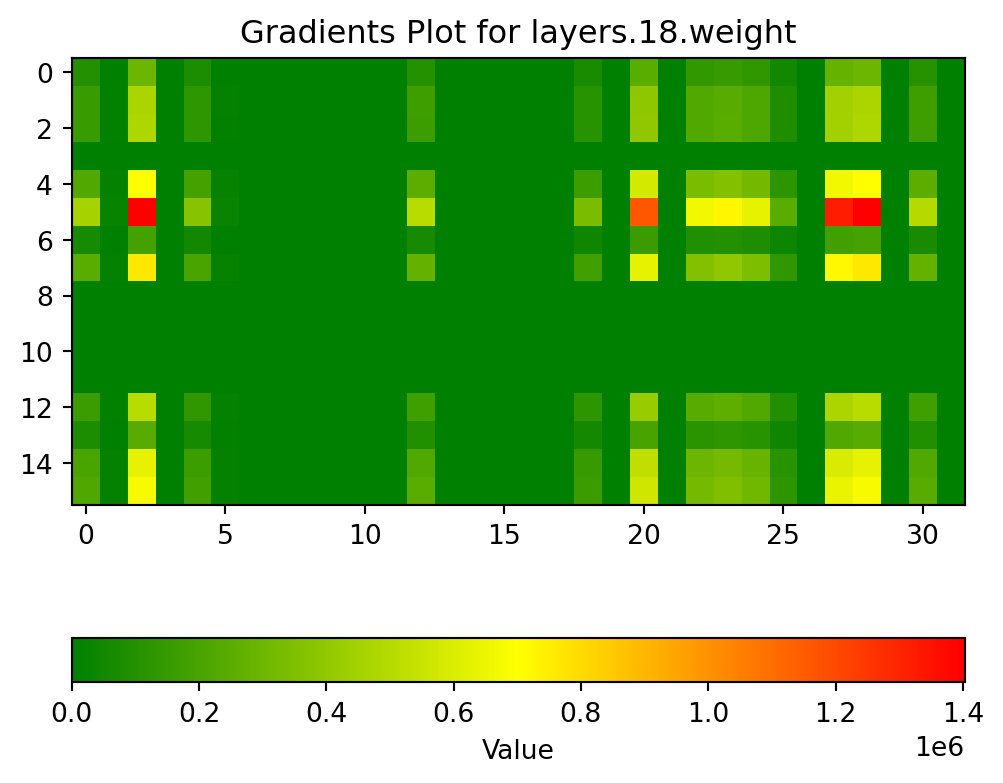

256 values in Layer layers.21.weight. Geometry: (16, 16)


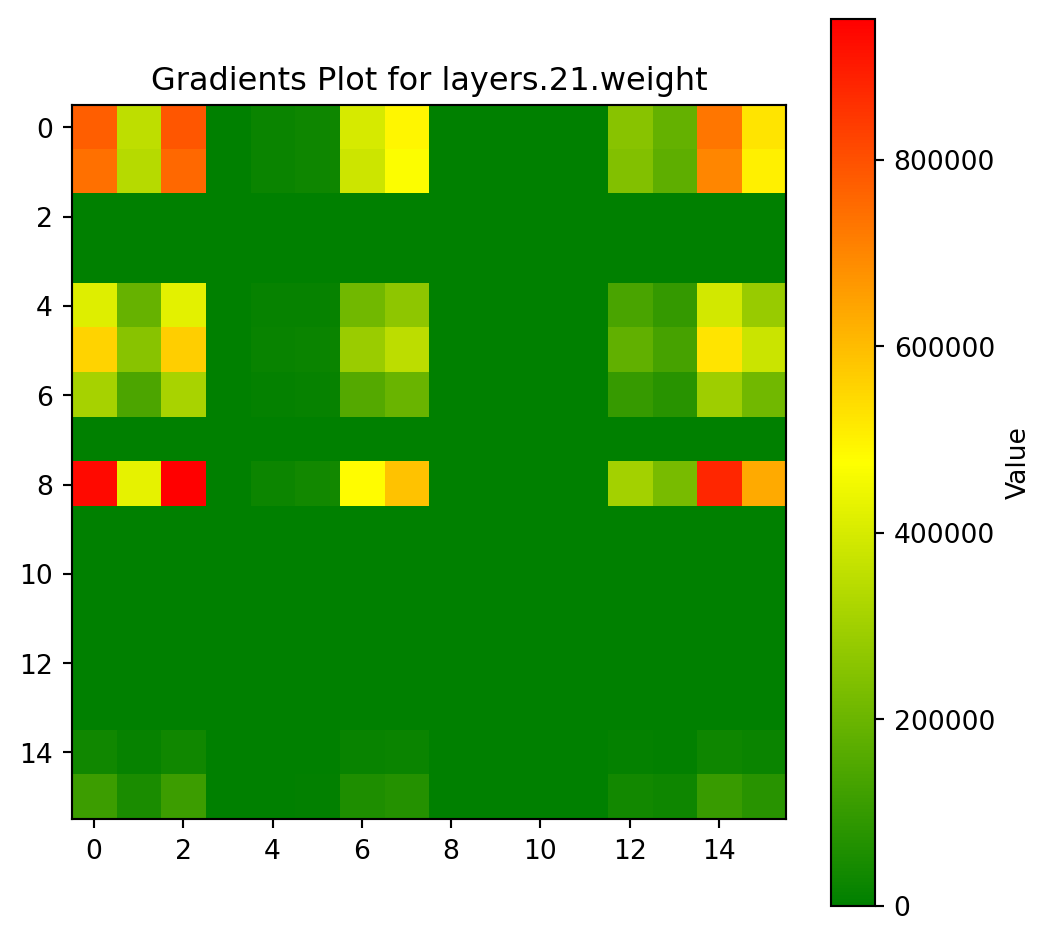

256 values in Layer layers.24.weight. Geometry: (16, 16)


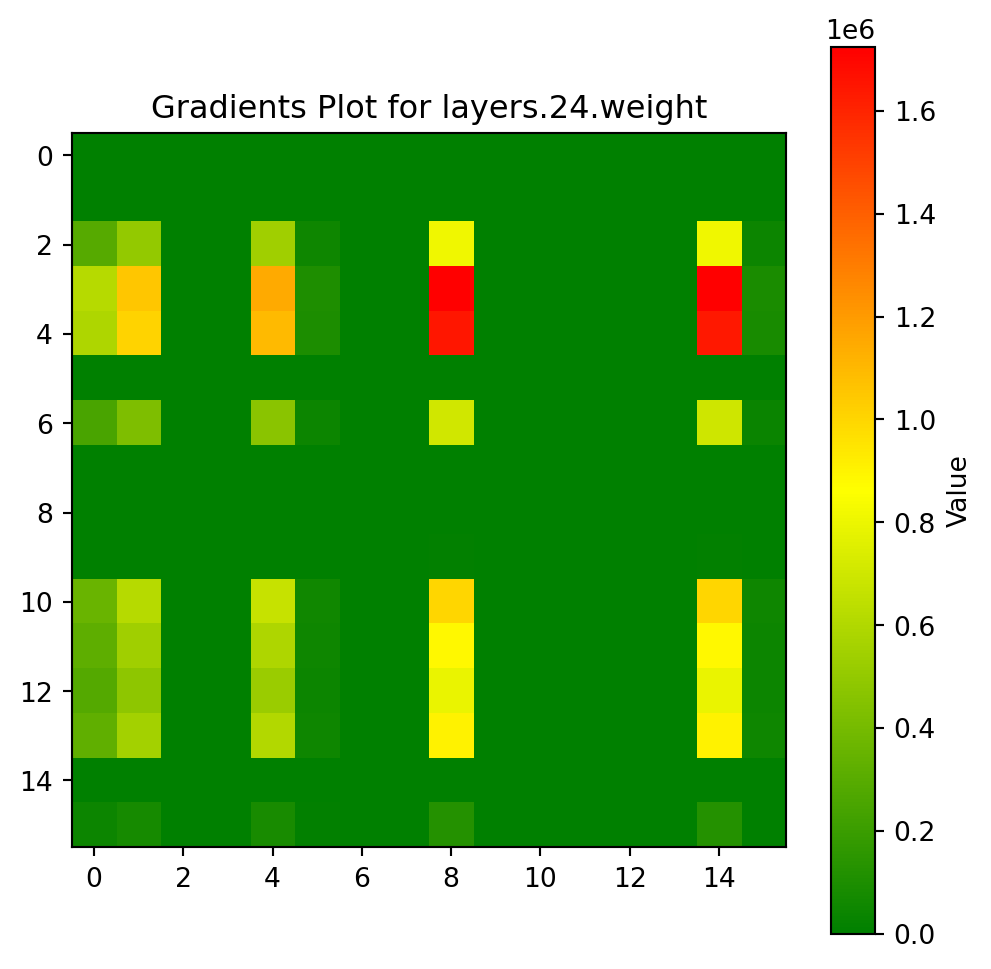

256 values in Layer layers.27.weight. Geometry: (16, 16)


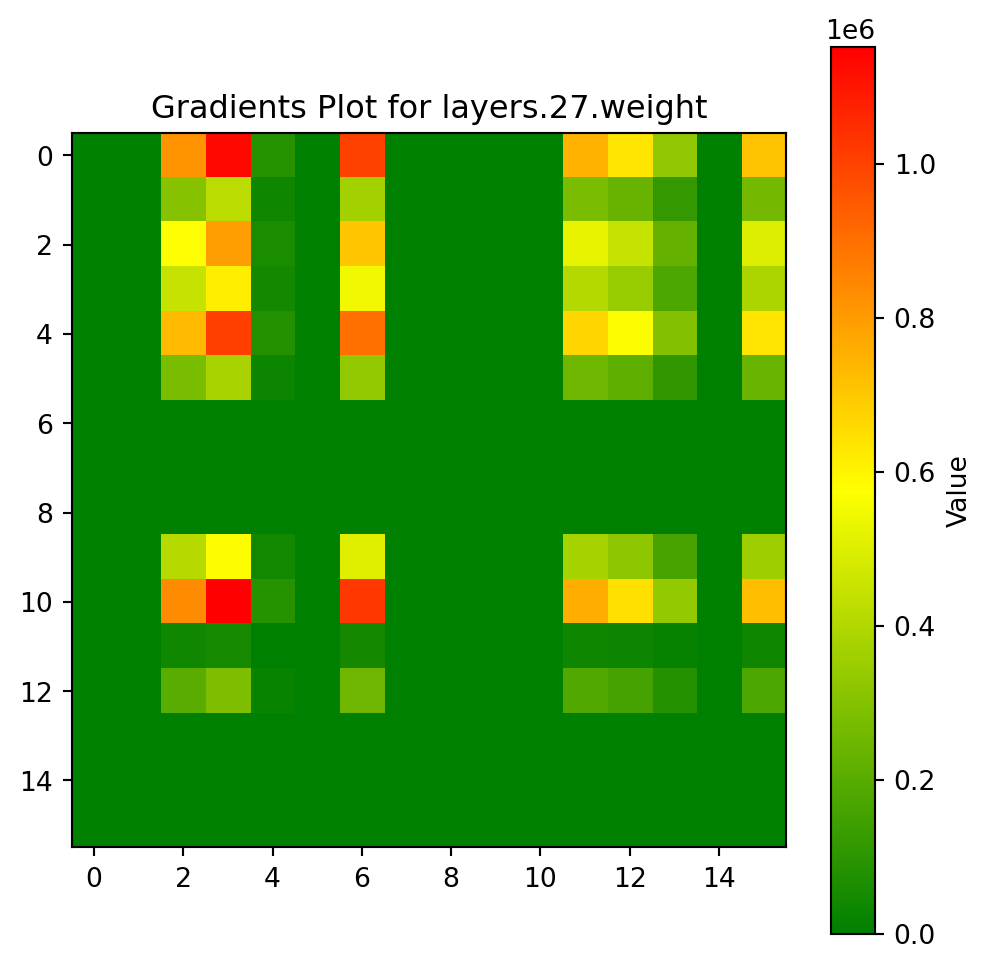

16 values in Layer layers.30.weight. Geometry: (1, 16)


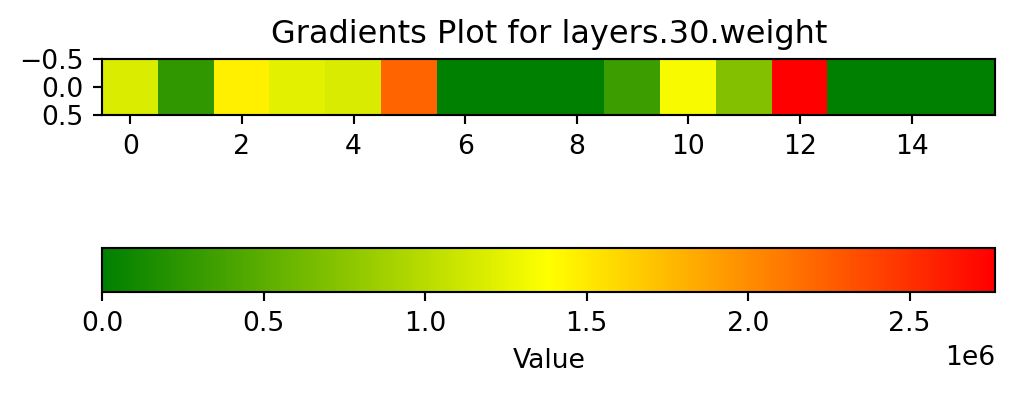

In [19]:
#| label: visualize_gradients
visualize_gradients(model, fun_control, batch_size, absolute=True, cmap="GreenYellowRed", figsize=(6, 6), device="mps")

stage: fit
full_sizefull_train_size: 0.6
full_sizeval_size: 0.24
full_sizetrain_size: 0.36
full_sizetest_size: 0.4
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.train_dataloader(). data_train size: 160
n:11


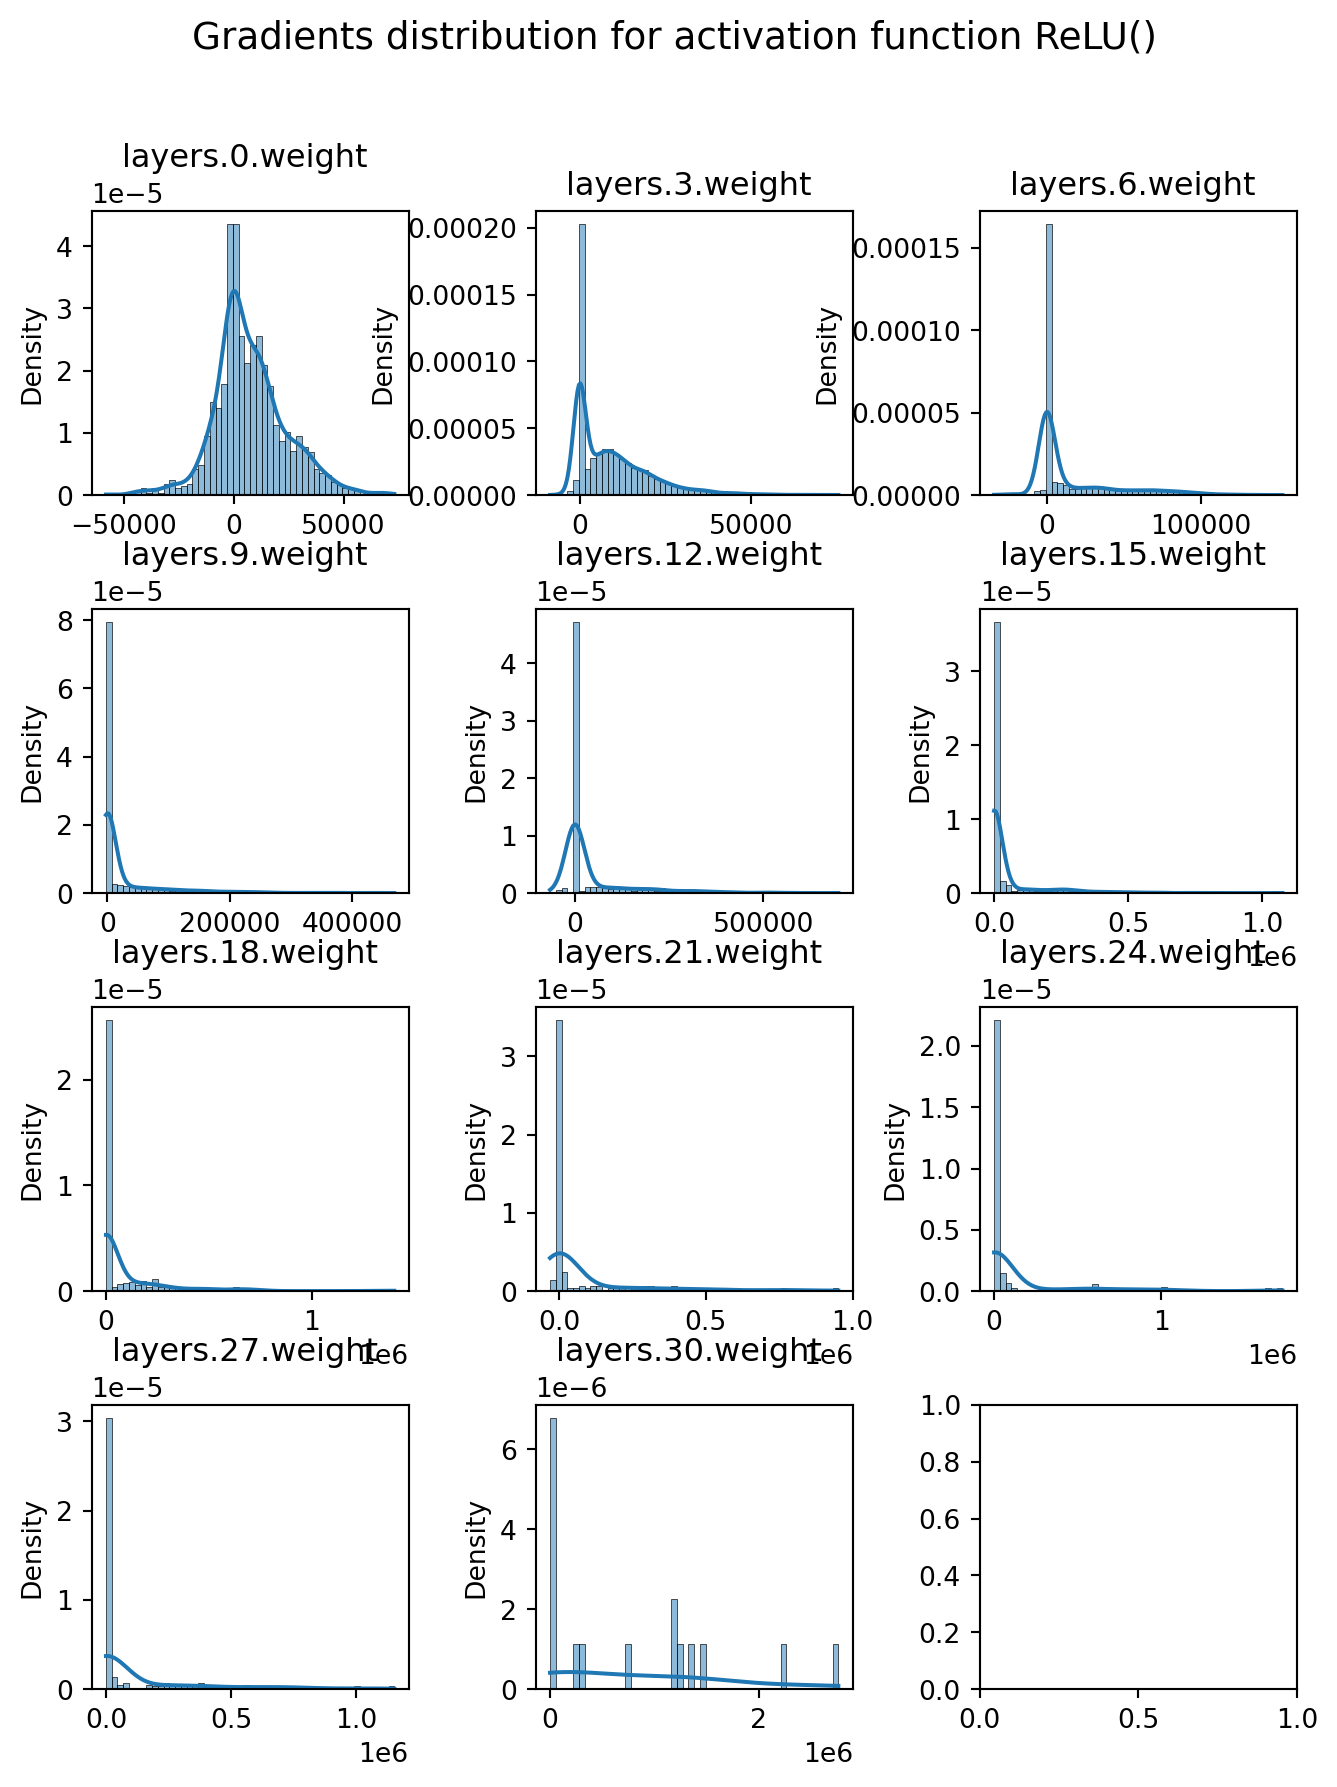

In [20]:
#| label: visualize_gradient_distributions
visualize_gradient_distributions(model, fun_control, batch_size=batch_size, color=f"C{0}", device="mps", columns=3)

## Feature Attributions

### Integrated Gradients


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2974.468505859375, 'hp_metric': 2974.468505859375}
config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_featu

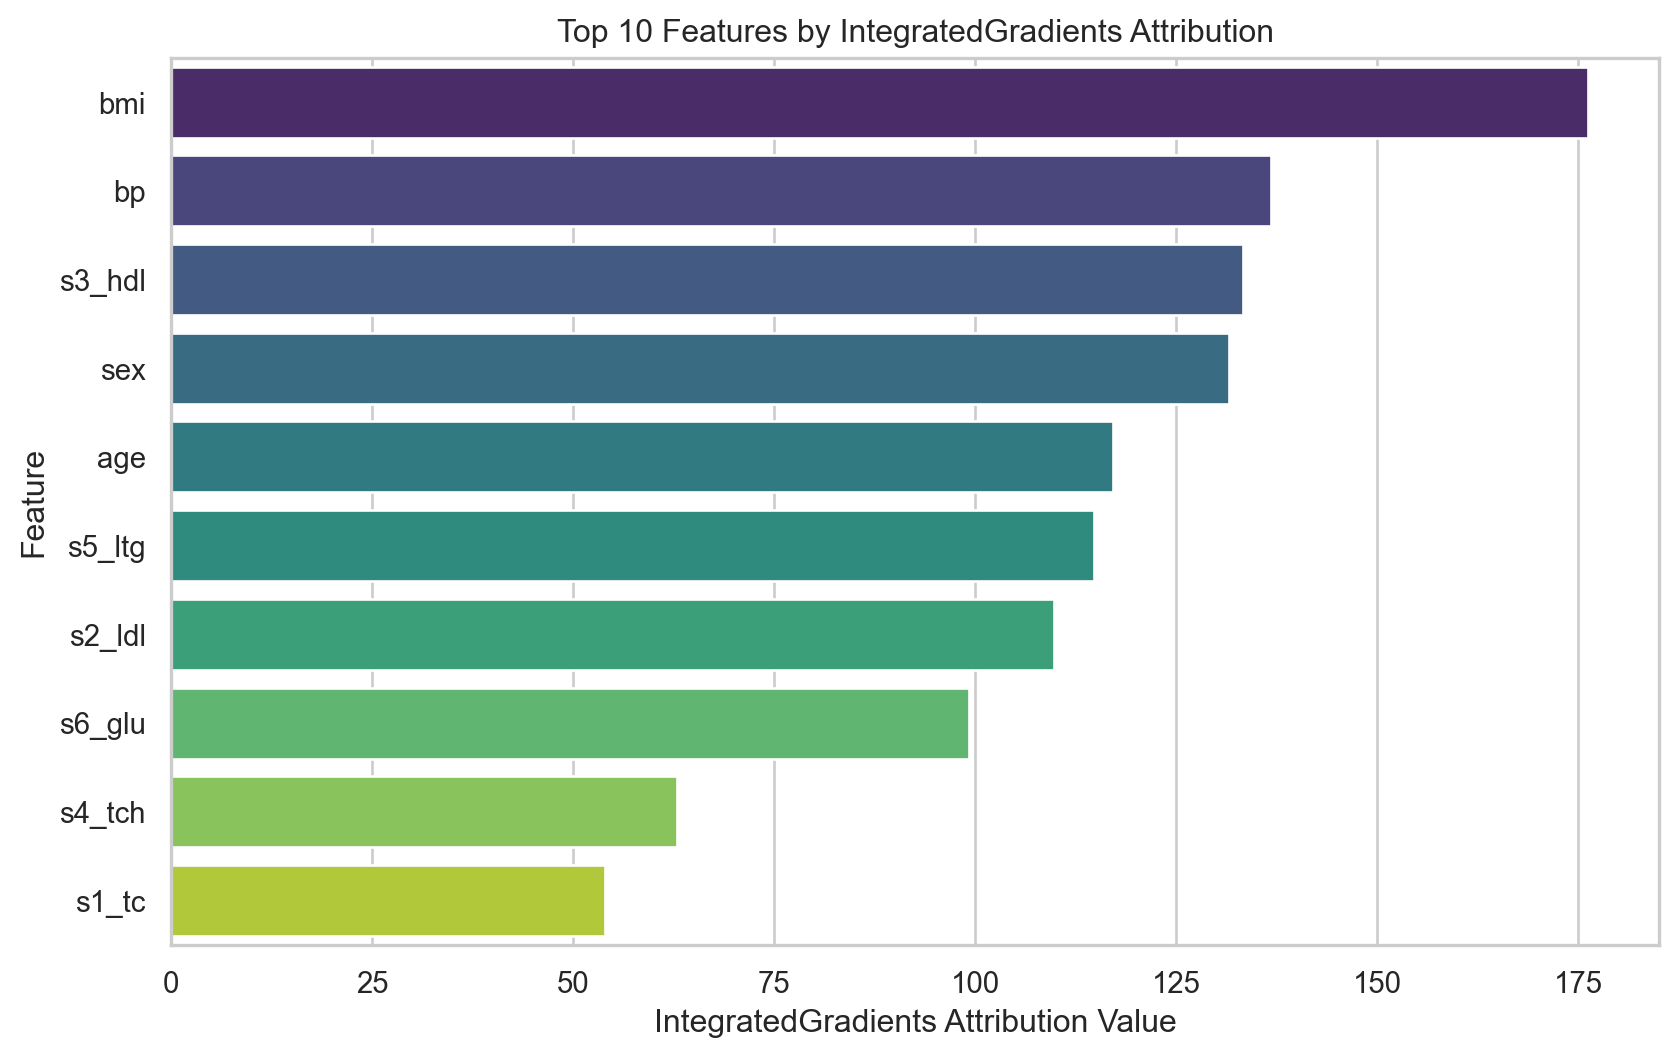

In [21]:
#| label: get_attributions_xai
from spotpython.plot.xai import get_attributions, plot_attributions
df_att = get_attributions(spot_tuner, fun_control, attr_method="IntegratedGradients", n_rel=10)
plot_attributions(df_att, attr_method="IntegratedGradients")

### Deep Lift


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3043.046630859375, 'hp_metric': 3043.046630859375}
config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_featu

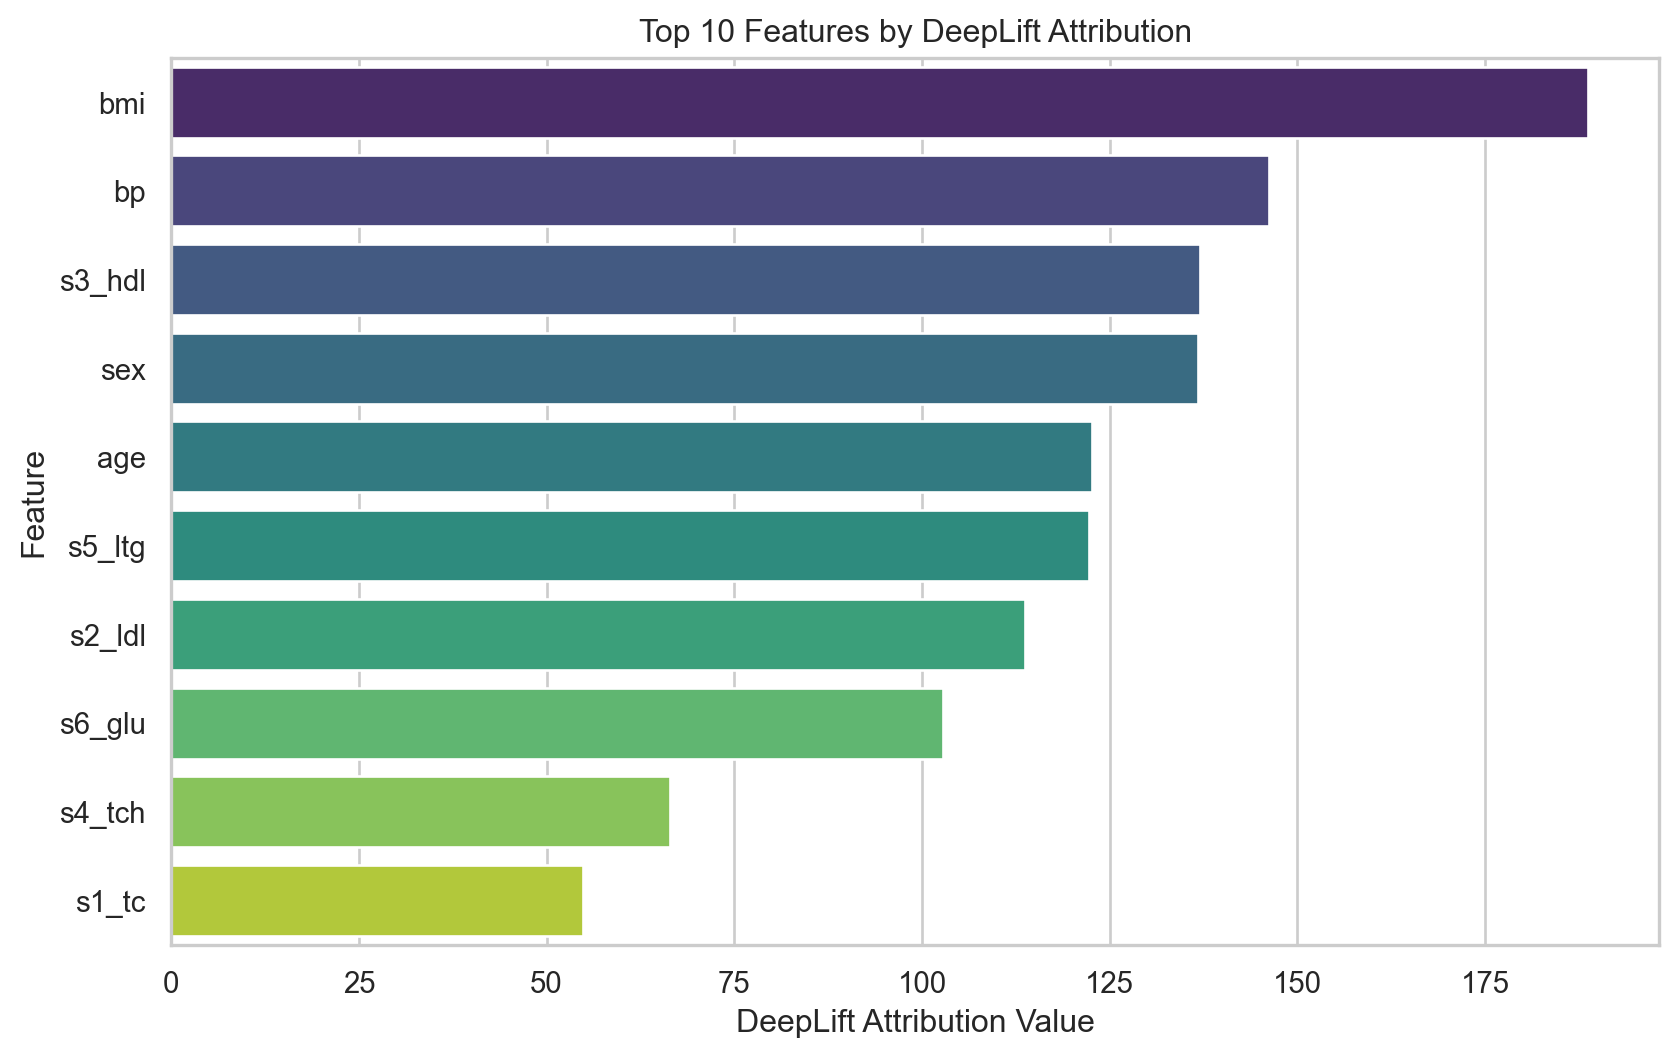

In [22]:
#| label: get_attributions_deep_lift
df_lift = get_attributions(spot_tuner, fun_control, attr_method="DeepLift",n_rel=10)
print(df_lift)
plot_attributions(df_lift,  attr_method="DeepLift")

### Feature Ablation


In [23]:
#| label: get_attributions_feature_ablation
df_fl = get_attributions(spot_tuner, fun_control, attr_method="FeatureAblation",n_rel=10)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2854.32080078125, 'hp_metric': 2854.32080078125}
config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_feature

   Feature Index Feature  FeatureAblationAttribution
0              2     bmi                  123.049416
1              3      bp                   88.806671
2              6  s3_hdl                   82.240189
3              1     sex                   74.943443
4              8  s5_ltg                   72.790390
5              0     age                   66.410706
6              5  s2_ldl                   57.816151
7              9  s6_glu                   50.867928
8              7  s4_tch                   34.481464
9              4   s1_tc                    8.255582


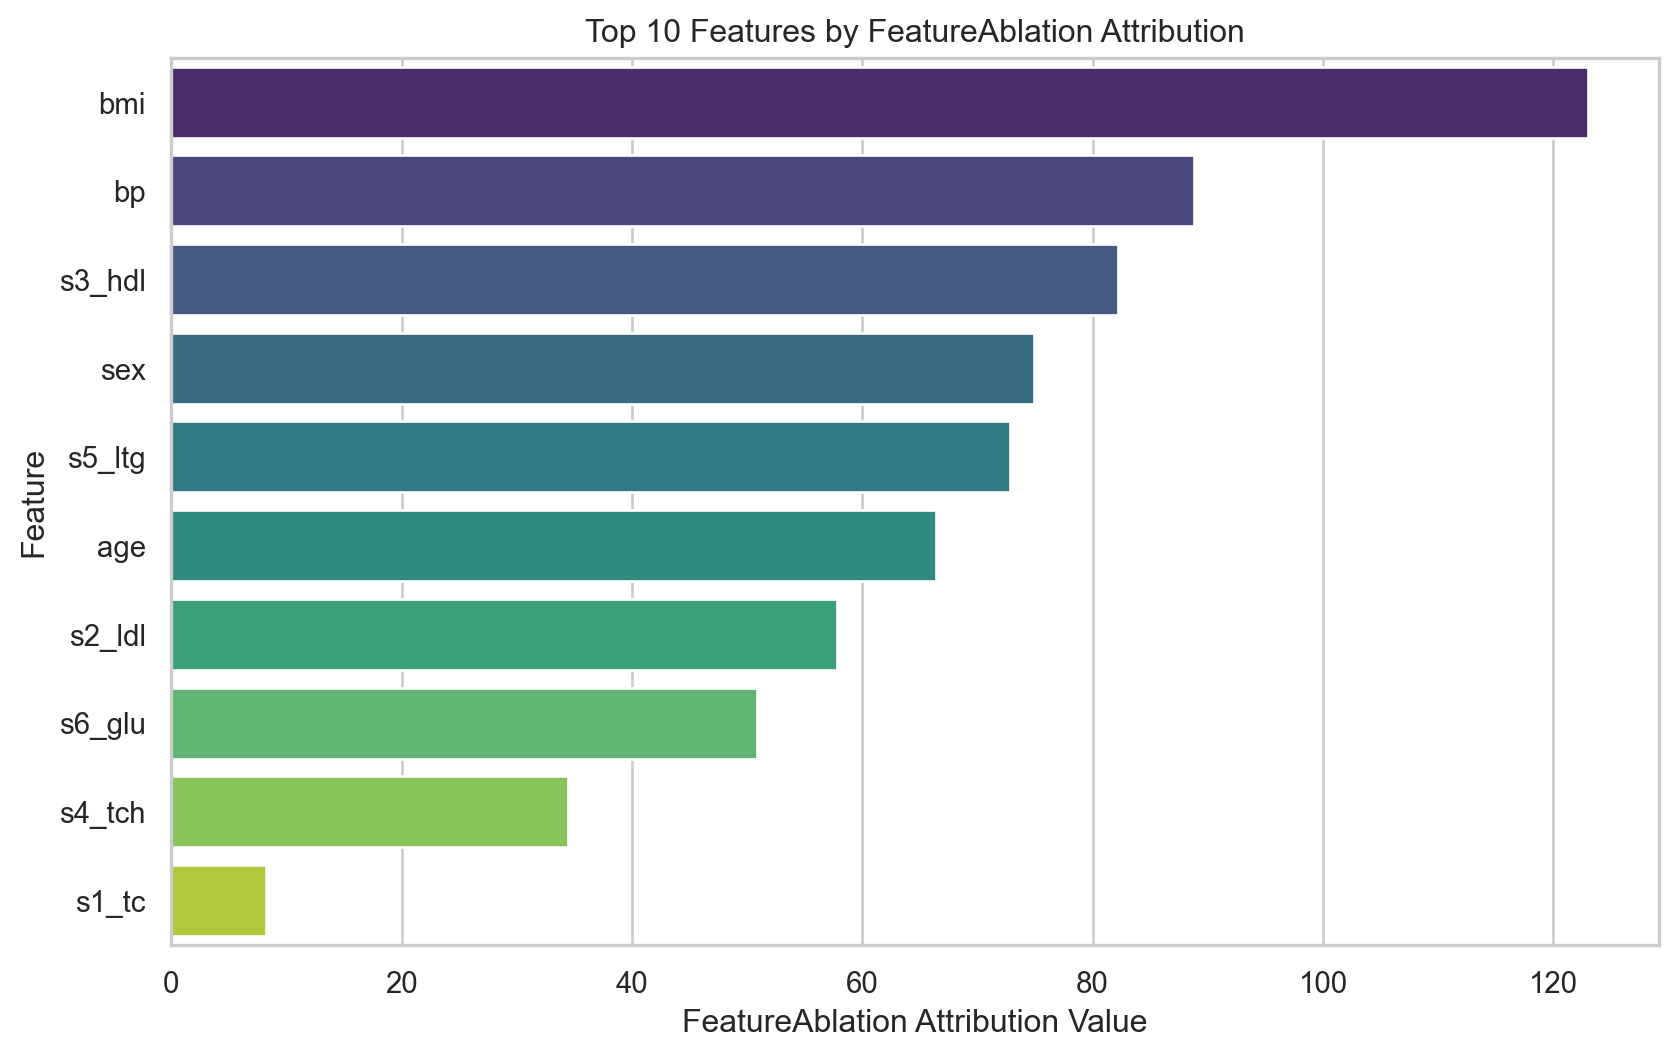

In [24]:
#| label: plot_attributions_feature_ablation
print(df_fl)
plot_attributions(df_fl, attr_method="FeatureAblation")

## Conductance


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 19.4 K | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3073.501220703125, 'hp_metric': 3073.501220703125}
config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_featu

train_model result: {'val_loss': 2838.6533203125, 'hp_metric': 2838.6533203125}
config: {'l1': 128, 'epochs': 4096, 'batch_size': 2048, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.020311634799104406, 'lr_mult': 4.322386097111191, 'patience': 32, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN from runs/saved_models/128_4096_2048_ReLU_Adam_0.0203_4.3224_32_False_kaiming_uniform_TRAIN/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.020311634799104406, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.020311634799104406, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.020311634799104406, inplace=False)
    (9): Linear(in_features=64, out_features=

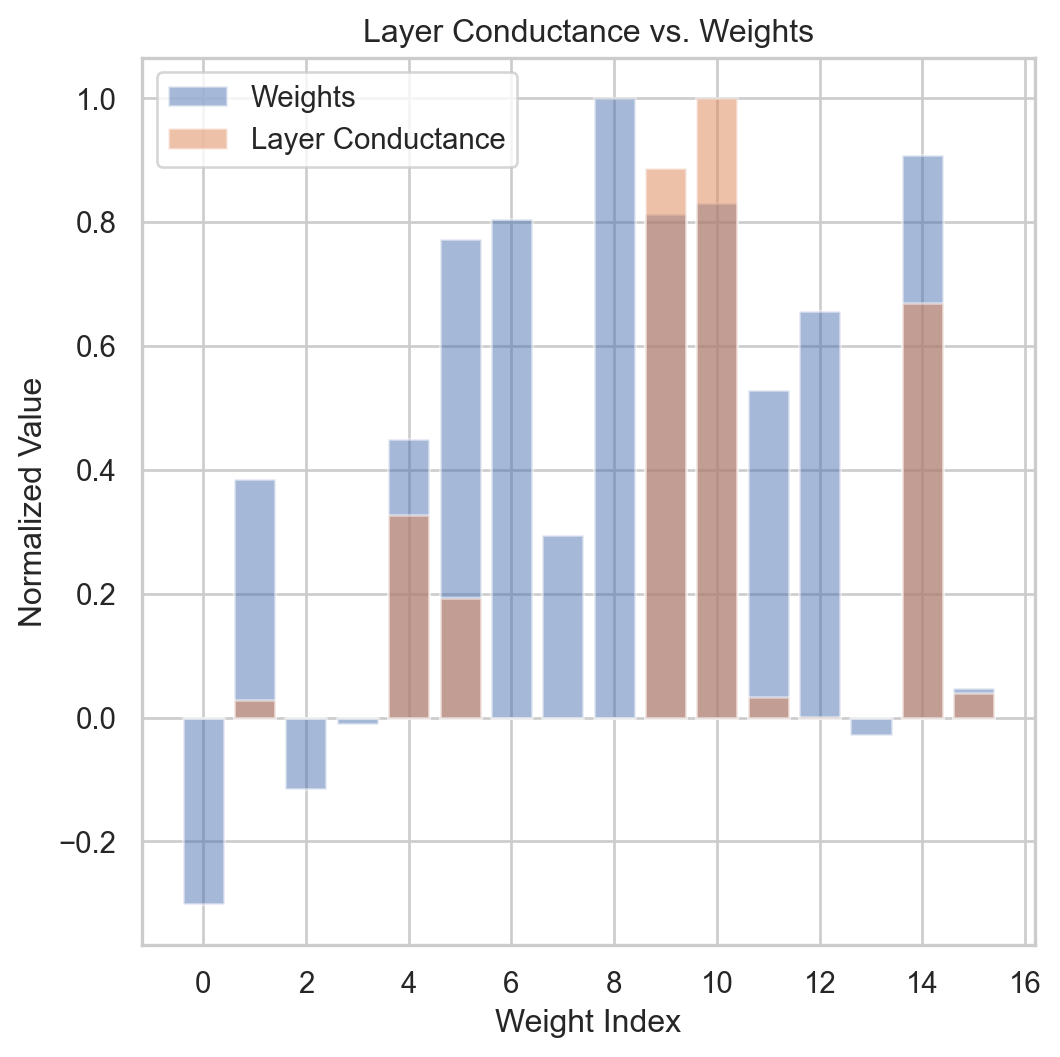

In [25]:
#| label: get_conductance
from spotpython.plot.xai import plot_conductance_last_layer, get_weights_conductance_last_layer
weights_last, layer_conductance_last = get_weights_conductance_last_layer(spot_tuner, fun_control)
plot_conductance_last_layer(weights_last, layer_conductance_last, figsize=(6, 6))